In [1]:
%load_ext autoreload
%autoreload 2

# King County Project

## Business Problem

A client in King County, WA wants to advise homeowners on **home improvement projects** that will **add to the sale value of their homes**.

**This advice should be based on data from the most recent full calendar year, 2019**.

### Sample Questions:
Enclosing a porch will increase the sale price of a home.

Converting a garage to a bedroom is a good way to increase the sale price of a home.

Upgrading to a forced-air heating system will increase the sale price of a home.

### Core Goals:
Create model

Interpret results

Make recomendations

# Project Alpha: 0.05
Using alpha = .05 for all statistical tests performed throughout the modeling process.

# Initial EDA Work

### Importing Libraries and Adjusting Settings

In [2]:
# import modules for eda and plotting
import pandas as pd
import numpy as np
import scipy.stats as stats

import os
import sys
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import sqlite3

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from src import functions as fn
from src import visualize as vz

# setting plots to inline
%matplotlib inline

# setting the max number of rows displayed
pd.options.display.max_rows = 300

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

## SQL Dataframe

### SQL Prelim Work

#### Created Database
Earlier, wrote up a [DB Creator](DB_Creator.ipynb) notebook and ran it to create an SQL database from the raw `.csv` files.

### Creating DataFrame From the Database

Connecting to the database, and creating a cursor object. Joining the database tables into a second main data frame. Lastly, checking basic information about the data frame.

In [3]:
# creating database, connection, and cursor

data_path = os.path.join(gparent,'data','KingDB.db')
conn = sqlite3.connect(data_path)  
cur = conn.cursor()

In [4]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('LOOK',), ('PARC',), ('RESB',), ('SALES',)]

### Joining Tables to Create the Main Data Frame

In [5]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM SALES AS SA
       JOIN PARC AS PA
       ON SA.Major = PA.Major
       AND SA.Minor = PA.Minor
       JOIN RESB AS RE
       ON PA.Major = RE.Major
       AND PA.Minor = RE.Minor
       """
df = pd.DataFrame(fn.fetch(cur, q))
df.columns = [i[0] for i in cur.description]

In [6]:
# checking info, shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251300 entries, 0 to 251299
Columns: 156 entries, ExciseTaxNbr to AddnlCost
dtypes: object(156)
memory usage: 299.1+ MB


### Creating the Lookup Data Data Frame

In [7]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM LOOK"""
look = pd.DataFrame(fn.fetch(cur, q))
look.columns = [i[0] for i in cur.description]

#### Checking the Lookup Data Frame

Getting basic info, checking the first row, description strings, and cleaning the columns.

In [8]:
# getting info for lookup data frame
look.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LUType         1208 non-null   object
 1   LUItem         1208 non-null   object
 2   LUDescription  1208 non-null   object
dtypes: object(3)
memory usage: 28.4+ KB


In [9]:
# checking first row
look.head(1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...


#### Checking & Cleaning Strings
Investigating and then cleaning dirty strings and checking results.

In [10]:
# checking strings
look.LUType.values[:2], look.LUItem.values[:2], look.LUDescription.values[:2]

(array(['1  ', '1  '], dtype=object),
 array(['1  ', '10 '], dtype=object),
 array(['LAND ONLY                                         ',
        'Land with new building                            '], dtype=object))

In [11]:
# cleaning strings
look['LUType'] = fn.col_stripper(look, 'LUType')
look['LUItem'] = fn.col_stripper(look, 'LUItem')
look['LUDescription'] = fn.col_stripper(look, 'LUDescription')

In [12]:
# checking results
print(look.LUType.values)
print(look.LUItem.values)
look.LUDescription.values

['1' '1' '1' ... '99' '99' '99']
['1' '10' '11' ... '3' '4' '5']


array(['LAND ONLY', 'Land with new building',
       'Household, single family units', ..., 'AVERAGE', 'ABOVE AVERAGE',
       'EXCELLENT'], dtype=object)

### Checking & Dealing with Columns in Main Data Frame
Working through the columns of the main data frame to narrow down the list of features to a more manageable size.

In [13]:
# checking columns
list(df.columns)

['ExciseTaxNbr',
 'Major',
 'Minor',
 'DocumentDate',
 'SalePrice',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Unnamed: 0',
 'Major',
 'Minor',
 'PropName',
 'PlatName',
 'PlatLot',
 'PlatBlock',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'SpecArea',
 'SpecSubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',

#### Removing `Unnamed: 0` Column

In [14]:
# using custom dropper function to remove unnamed column found above
fn.dropper(df, ['Unnamed: 0'], True)

## Checking `PropertyType`, `PropertyClass`, `PropType`


In [15]:
df[['PropertyType', 'PropertyClass', 'PropType']].head(3)

,PropertyType,PropertyClass,PropType
0,3,8,R
1,2,8,R
2,3,8,R


Checking Lookup Codes

In [16]:
fn.lookup(look, 1), fn.lookup(look,4)

(   LUType LUItem                                      LUDescription
 0       1      1                                          LAND ONLY
 1       1     10                             Land with new building
 2       1     11                     Household, single family units
 3       1     12  Multiple family residence (Residential, 2-4 un...
 4       1     13  Multiple family residence (Residential, 5+ units)
 5       1     14                           Residential condominiums
 6       1     15                        Mobile home parks or courts
 7       1     16                                      Hotels/motels
 8       1     17                              Institutional lodging
 9       1     18          All other residential not elsewhere coded
 10      1     19                                 Vacation and cabin
 11      1      2                             LAND WITH NEW BUILDING
 12      1     21                          Food and kindred products
 13      1     22                 

#### Making `PropType` Lookup Data Frame

In [17]:
# PropType Codes 
codes = ['C', 'K', 'M', 'N', 'R', 'T', 'U', 'X']
ptypes = ['Commercial', 'Condominium', 'Coal & Mineral Rights',\
            'Mining', 'Residential', 'Timber', 'Undivided Interest', 'Exempt']
pt = {'LUItem': codes, 'LUDescription': ptypes}
PropTypes = pd.DataFrame().from_dict(pt)
PropTypes

,LUItem,LUDescription
0,C,Commercial
1,K,Condominium
2,M,Coal & Mineral Rights
3,N,Mining
4,R,Residential
5,T,Timber
6,U,Undivided Interest
7,X,Exempt


#### Checking Number of Each Property Type

In [18]:
df.groupby('PropertyType').size().sort_values(ascending=False)

PropertyType
3     138077
11     88244
2      11250
1       5351
10      4256
0       1285
12       741
91       590
14       478
5        336
4        209
18        72
13        68
99        54
6         41
45        41
94        37
59        37
96        31
83        20
19        14
80         8
88         7
9          7
95         5
65         5
17         4
69         3
47         3
15         2
50         2
21         2
30         2
68         2
76         2
22         2
90         1
93         1
92         1
23         1
44         1
89         1
86         1
24         1
33         1
32         1
51         1
63         1
dtype: int64

## Light Data Cleaning

Changing datestrings to datetime objects,  and sale price strings to floats in the main pandas dataframe. Adding a 'DocumentYear' column to main the data frame.

In [19]:
# changing date strings to datetime objects
df.DocumentDate = pd.to_datetime(df.DocumentDate)

# adding a document year column
df['DocumentYear'] = df['DocumentDate'].apply(lambda x: x.year)

# converting SalePrice string to float
df['SalePrice'] = df['SalePrice'].astype('float')

### Checking For Null Values

In [20]:
# checking nulls and shape
print(df.isna().sum())
df.shape

ExciseTaxNbr                   0
Major                          0
Minor                          0
DocumentDate                   0
SalePrice                      0
RecordingNbr                   0
Volume                         0
Page                           0
PlatNbr                        0
PlatType                       0
PlatLot                        0
PlatBlock                      0
SellerName                     0
BuyerName                      0
PropertyType                   0
PrincipalUse                   0
SaleInstrument                 0
AFForestLand                   0
AFCurrentUseLand               0
AFNonProfitUse                 0
AFHistoricProperty             0
SaleReason                     0
PropertyClass                  0
SaleWarning                    0
Major                          0
Minor                          0
PropName                   11473
PlatName                   29223
PlatLot                        0
PlatBlock                      0
Range     

(251300, 156)

### Checking `'SpecArea'` and `'SpecSubArea'` columns.

In [21]:
# inspecting columns with custom chunker() function
fn.chunker(df, ['SpecArea', 'SpecSubArea'])

,SpecArea,SpecSubArea
0,None,None
1,None,None
2,None,None


It looks like the `'SpecArea'` and `'SpecSubArea'` are extraneous columns for modeling purposes so they will be dropped.

In [22]:
# dropping columns and checking first row
fn.dropper(df, ['SpecArea', 'SpecSubArea'], True)
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,0,1,1963,0,0,0,0,3,0,2015


### Inspecting Columns with Null Values

In [23]:
# checking problematic columns
li = ['PropName', 'PlatName', 'DirectionPrefix', 'DirectionSuffix', 'ZipCode']
fn.chunker(df, li)

,PropName,PlatName,DirectionPrefix,DirectionSuffix,ZipCode
0,,OLYMPIC TERRACE ADD,,S,98188
1,None,VINTNER'S PLACE,NE,,None
2,,LAKE UNION ADD,,N,98103


#### Keeping `'ZipCode'` Column but Dropping Others

The othe columns have to do with Plat Mapping and seem irrelevant to the model. Zip Codes can have value as proxy indicators so may be useful later. Keeping for now.

In [24]:
# dropping extraneous columns
fn.dropper(df, li[:4], True)

In [25]:
# checking head
df[df.isna().any(axis=1)].head(3)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
1,2841697,894677,0240,2016-12-21,818161.0,20161228000896,,,,,...,0,0,2016,0,0,0,0,3,0,2016
20,2723231,912610,0736,2015-01-30,0.0,20150409000784,,,,,...,0,0,2013,0,0,0,0,3,0,2015
24,2799723,162404,9140,2016-05-18,414950.0,20160601000406,,,,,...,0,0,2016,0,0,0,0,3,0,2016


In [26]:
# checking number of null zips
df.isna().any(axis=1).sum()

39980

### Replacing Null Zip Codes With `'00000'`
Giving the nulls a standard length for cleaning purposes.

In [27]:
# filling NaNs with '00000'
df.fillna('00000', inplace=True)

In [28]:
# checking work
df['ZipCode'].isna().sum()

0

In [29]:
# checking unique zipcodes
df['ZipCode'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98058 ', '98224',
       '98057', '98354', '98134', '98050', '98104', '98000', '98132',
       '98026', '98204', '98042-3001', '98068', '98023-7330',
       '98074-9301', '98034-2540', '98097', '8126', '9059', '28028',
       'A on plans', '98189'

### Cleaning ZipCode Data
Adding new `ZipClean` column and cleaning zip code data by splitting 9-digit code and dropping last 4 digits. Also, stripping whitespaces and dropping any rows with codes not of length 5. Lastly, dropping original `ZipCode` column.

In [30]:
# adding new column with split codes
df['ZipClean']=df.groupby('ZipCode')['ZipCode'].transform(lambda x: x.str.split('-').str[0])

In [31]:
# stripping whitespace
df['ZipClean'] = fn.col_stripper(df,'ZipClean')

In [32]:
# making a list of uniques
uniques = df['ZipClean'].unique()

In [33]:
# making a list of dirty strings
dirty_zips = [x for x in uniques if len(x) != 5]

In [34]:
# printing list of dirty strings
dirty_zips

['8126',
 '9059',
 'A on plans',
 '',
 '98',
 '988122',
 '981182019',
 '3',
 '9800',
 '9859',
 '9804']

In [35]:
# dropping rows with dirty zip codes
df = df[~df.ZipClean.isin(dirty_zips)]

In [36]:
# checking cleaned data
df['ZipClean'].unique()

array(['98188', '00000', '98103', '98115', '98106', '98019', '98038',
       '98070', '98168', '98092', '98125', '98030', '98007', '98116',
       '98023', '98109', '98033', '98146', '98117', '98052', '98058',
       '98045', '98118', '98166', '98034', '98004', '98133', '98006',
       '98002', '98065', '98075', '98010', '98102', '98077', '98011',
       '98074', '98042', '98032', '98053', '98198', '98051', '98001',
       '98008', '98059', '98003', '98027', '98056', '98028', '98126',
       '98107', '98122', '98155', '98105', '98022', '98199', '98136',
       '98040', '98047', '98177', '98031', '98005', '98148', '98108',
       '98178', '98055', '98144', '98112', '98072', '98119', '98029',
       '98024', '98302', '98039', '98288', '98014', '98224', '98057',
       '98354', '98134', '98050', '98104', '98000', '98132', '98026',
       '98204', '98068', '98097', '28028', '98189', '98018', '98113',
       '98422', '89045', '98085', '98405', '98043', '98009', '90333',
       '98121', '980

In [37]:
# dropping original zip code column
fn.dropper(df, 'ZipCode', True)

In [38]:
# checking work
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


### Checking for Duplicate Columns

Before going any further, finding and dropping any dupes.

In [39]:
# checking for duplicate columns
df.loc[:, df.columns.duplicated()].head(3)

,Major,Minor,PlatLot,PlatBlock,Major,Minor
0,638580,0110,11,,638580,0110
1,894677,0240,24,,894677,0240
2,408330,4150,9,42,408330,4150


In [40]:
# dropping duplicate column and checking shape
df = df.loc[:,~df.columns.duplicated()]
print(df.shape)
df.head(1)

(251279, 144)


,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188


##  Swapping Column Order & Adding an `'ID'` Feature
Doing a little house cleaning by moving the `'SalePrice'` target variable to the front of the data frame and creating an `'ID'` feature by combining the `'Major'` and `'Minor'` values into a single string. Moving the `'ID'` feature to second position in the data frame.

In [41]:
# moving target variable to the front column of the df
columns = list(df.columns)
columns = [columns[4]] + columns[:4] + columns[5:]
df = df[columns]
df.head(3)

,SalePrice,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,2743355,638580,0110,2015-07-14,20150715002686,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,2841697,894677,0240,2016-12-21,20161228000896,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
2,0.0,2860712,408330,4150,2017-03-15,20170426000922,,,,,...,0,1906,0,0,0,0,4,0,2017,98103


#### Creating `ID` Feature and Moving it to Front of Data Frame

In [42]:
# creating 'ID' column
df['ID'] = df['Major'] + df['Minor']

In [43]:
# getting info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251279 entries, 0 to 251299
Columns: 145 entries, SalePrice to ID
dtypes: datetime64[ns](1), float64(1), int64(1), object(142)
memory usage: 279.9+ MB


In [44]:
# moving ID column to the front column of the df
columns = list(df.columns)
columns = columns[:1] + [columns[144]] + columns[1:144]
df = df[columns]
df.head(1)

,SalePrice,ID,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,638580,0110,2015-07-14,20150715002686,,,,...,1,1963,0,0,0,0,3,0,2015,98188


In [45]:
fn.dropper(df, ['Major', 'Minor'], True)

## Checking For Duplicate Rows
Looking for duped rows before cleaning columns.

In [46]:
# checking for duplicate rows
df[df.duplicated()]

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean


# Data Understanding
Getting a feel for what is going on in data.

### Checking For Duplicate `ID`s

In [47]:
# checking for duplicated ids
dupe_ids = df[df.duplicated(subset=['ID'], keep=False)]
print(dupe_ids.shape)
dupe_ids.head(3)

(123199, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
0,190000.0,6385800110,2743355,2015-07-14,20150715002686,,,,,,...,1,1963,0,0,0,0,3,0,2015,98188
1,818161.0,8946770240,2841697,2016-12-21,20161228000896,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
3,0.0,5101404256,2813396,2016-07-25,20160802000964,,,,,,...,0,1949,0,0,0,0,3,0,2016,98115


#### Filtering Zero Prices

In [48]:
# getting non-zero rows
nz_dupes = dupe_ids[dupe_ids['SalePrice'] != 0].sort_values(by='ID')
print(nz_dupes.shape)
nz_dupes.head()

(76237, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
144761,394950.0,0001000040,2804519,2016-06-17,20160623001164,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
198044,126000.0,0001000040,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000
60412,380000.0,0001000042,2809927,2016-07-07,20160718001671,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
192863,485500.0,0001000042,3018323,2019-10-29,20191031001228,,,,,,...,0,2016,0,0,0,0,3,0,2019,00000
198045,126000.0,0001000042,2760609,2015-10-06,20151009000683,,,,,,...,0,2016,0,0,0,0,3,0,2015,00000


#### Focusing in on Some Features to Get Context

In [49]:
# getting context
nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']].head(5)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
144761,394950.0,0001000040,2804519,20160623001164,2016-06-17,1502 M ST NE,3
198044,126000.0,0001000040,2760609,20151009000683,2015-10-06,1502 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1


#### Using Lookup Codes on `PropertyType`

In [50]:
li = [1, 3, 11]
for x in li:
    print(fn.lookup(look,1,x))

  LUType LUItem LUDescription
0      1      1     LAND ONLY
   LUType LUItem             LUDescription
21      1      3  LAND WITH PREV USED BLDG
  LUType LUItem                   LUDescription
2      1     11  Household, single family units


#### Checking `ExciseTaxNbr`

In [51]:
ext_nb = df[df.duplicated(subset=['ExciseTaxNbr'], keep=False)]
ext_nb[ext_nb['SalePrice'] != 0].head()

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
132,1512000.0,9822700460,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
133,1512000.0,9822700465,2888358,2017-09-08,,,,,,,...,0,2019,0,0,0,0,3,0,2017,98105
173,875000.0,1522059185,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000
174,875000.0,1522059183,2809560,2016-07-13,20160715001611,,,,,,...,0,2016,0,0,0,0,3,0,2016,00000
175,875000.0,1522059187,2809560,2016-07-13,20160715001611,,,,,,...,0,2017,0,0,0,0,3,0,2016,00000


### An Example `ID`
Focusing on a single `ID` for a closer look at how the data works. 

In [52]:
example = nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']]
example[example.ID == '0001000042'].sort_values(by='DocumentDate')

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11


### Preliminary Understanding

It seems that the `ID` (`Major` + `Minor`) feature is tied to the property address, and `ExciseTaxNumber` is tied to the transaction date. In the example dataframe above, we can see the history of a single parcel of land. In 2015, the undeveloped land (`PropertyType 1`) was sold. 2016 saw it sold again, with some type of building attached (`PropertyType 3`). Finally, the sale in 2019 was recorded as a `PropertyType` 11, indicating that a home was built on the land. It looks like **`PropertyType` 11** and **12** (and maybe **13** ) will be the primary types in the model data frame.

## Diving Deeper into the Data
Looking at a property with multiple buildings.

In [53]:
deep = df[df.ID == '0822119001']
deep = deep[deep['DocumentYear'] == 2019]
deep = deep[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'BldgNbr', 'PropertyType']]
deep.shape

(63, 8)

In [54]:
deep.head(2)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0


#### Corrupt Data
Looks like there is some corrupt `PropertyType` data with an invalid code of '0'.
Checking all 63 rows.

In [55]:
deep

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0
135746,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,11,0
135747,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,12,0
135748,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,13,0
135749,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,14,0
135750,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,15,0
135751,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,16,0
135752,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,17,0
135753,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,18,0


#### Checking Number of Buildings

In [56]:
len(deep.BldgNbr.unique())

21

Looks like there are 42 invalid entries. Dropping them.

#### Dropping '0' Values

In [57]:
drop_idx = deep[deep.PropertyType == '0'].index
deep.drop(drop_idx, inplace=True)

In [58]:
print(deep.shape)
deep.head(2)

(21, 8)


,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
137341,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,1,3
137342,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,10,3


#### Looking Good
The shape of the data frame make more sense after dropping rows.

## Deeper Understanding
Feeling confident that `'0'` `SalePrice` & `PropertyType` rows can be safely removed for cleaning purposes after performing the above analysis. 

## Dropping Zeroes

In [59]:
# dropping 0 prices
drop_idx = df[(df.SalePrice == 0)].index
df.drop(drop_idx, inplace=True)

In [60]:
df.shape

(173621, 143)

In [61]:
# dropping'0' propertytypes
drop_idx = df[df.PropertyType == '0'].index
df.drop(drop_idx, inplace=True)

In [62]:
df.shape

(172793, 143)

## 2019 Data

Since we want to base our model on 2019 data, we are going to isolate the 2019 information into a new data frame and use it to define our target and predictors.

#### Creating Initial 2019 DataFrame

Creating data frame and checking basic information

In [63]:
# isolating 2019 data
df = df[df['DocumentYear']==2019]

In [64]:
# checking data frame shape and looking for NaNs
print(df.shape)
df.isna().sum()

(29761, 143)


SalePrice                 0
ID                        0
ExciseTaxNbr              0
DocumentDate              0
RecordingNbr              0
Volume                    0
Page                      0
PlatNbr                   0
PlatType                  0
PlatLot                   0
PlatBlock                 0
SellerName                0
BuyerName                 0
PropertyType              0
PrincipalUse              0
SaleInstrument            0
AFForestLand              0
AFCurrentUseLand          0
AFNonProfitUse            0
AFHistoricProperty        0
SaleReason                0
PropertyClass             0
SaleWarning               0
Range                     0
Township                  0
Section                   0
QuarterSection            0
PropType                  0
Area                      0
SubArea                   0
DistrictName              0
LevyCode                  0
CurrentZoning             0
HBUAsIfVacant             0
HBUAsImproved             0
PresentUse          

In [65]:
# checking first few rows
df.head(3)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,20191226000848,,,,,,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,20190730001339,,,,,,...,0,1994,0,0,0,0,3,2500,2019,98038
12,450000.0,1402810020,2993601,2019-06-04,20190614000489,,,,,,...,0,1986,0,0,0,0,3,0,2019,98019


## Narrowing Data Down to Single Family Homes
Single family homes seem to be most relevant to the project.

In [66]:
df = df[df.PropertyType == '11']
df.shape

(18804, 143)

# Inspecting Columns and Dropping Extraneous Features
Working through the list of columns step by step and removing features that seem like they will have minimal impact of the model.

In [67]:
# printing list of columns and copying it to external text file for ease of use
list(df.columns)

['SalePrice',
 'ID',
 'ExciseTaxNbr',
 'DocumentDate',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',
 'WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityI

## `SALES` Table Columns
Inspecting and dropping columns from the `SALES` table.

#### Checking First Batch of Columns

Seem to be a mix of blank columns and administrative information that will probably have no effect on the model.

In [68]:
# checking columns 
li = ['RecordingNbr', 'Volume', 'Page', 'PlatNbr' ,'PlatType',\
    'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName']
fn.chunker(df,li)

,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName
5,20191226000848,,,,,,,DOYLE REGAN M+STERLING C ...,SHAW HEATHER C ...
6,20190730001339,,,,,,,CRAMER NEIL C+PAM R+ET AL ...,HANSON BRYAN L+KAILI ...
69,,,,,,,,BROWN MARK E+MARCIE K ...,MEDVED ROBERT J+JENNIFER E ...


Dropping columns and checking the results.

In [69]:
# dropping blank and extraneous columns
fn.dropper(df, li, True)

In [70]:
# checking first row
df.head(1)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,3,N,N,N,...,0,1989,0,0,0,0,3,0,2019,98019


In [71]:
# creating data frame to inspect latest batch of columns
li =['SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning']
fn.chunker(df, li)

,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
5,3,N,N,N,N,1,8,
6,3,N,N,N,N,1,8,
69,3,N,N,N,N,1,8,


#### Using Lookup Table For More Info on the Features
Checking lookup data and dropping columns. Looking up info on the `SaleInstrument` and `PropertyClass` features.

In [72]:
# using custom lookup function to print info 
fn.lookup(look, 6), fn.lookup(look, 4)

(     LUType LUItem                    LUDescription
 1002      6      1                             None
 1003      6     10             Real Estate Contract
 1004      6     11           Purchaser's Assignment
 1005      6     13              Seller's Assignment
 1006      6     15                  Quit Claim Deed
 1007      6     18                   Trustees' Deed
 1008      6     19                  Executor's Deed
 1009      6      2                    Warranty Deed
 1010      6     20                   Fiduciary Deed
 1011      6     21                   Sheriff's Deed
 1012      6     22           Bargain and Sales Deed
 1013      6     23                   Receivers Deed
 1014      6     24             Deed of Personal Rep
 1015      6     25         Judgment Per Stipulation
 1016      6     26            Other - See Affidavit
 1017      6     27                             DEED
 1018      6     28  Forfeiture Real Estate Contract
 1019      6      3          Statutory Warrant

#### Dropping Columns
Seems to be more administrative data that can be safely dropped.

In [73]:
# dropping extraneous columns
fn.dropper(df, li, True)

## `PARC` Table Columns
Inspecting and dropping columns from the `PARC` table.

#### Inspecting Next Batch and Checking `'DistrictName'` Feature

In [74]:
# checking columns
li = ['Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning']
fn.chunker(df, li)

,Range,Township,Section,QuarterSection,PropType,Area,SubArea,DistrictName,LevyCode,CurrentZoning
5,6,26,13,SE,R,70,2,DUVALL,1155,R4.5
6,6,22,27,SW,R,56,3,MAPLE VALLEY,1813,R-6
69,6,22,27,NW,R,56,3,MAPLE VALLEY,1813,R-4


In [75]:
# getting unique values
print(len(df['DistrictName'].unique()))
df['DistrictName'].unique()

40


array(['DUVALL', 'MAPLE VALLEY', 'BELLEVUE', 'AUBURN', 'KING COUNTY',
       'KENT', 'SEATTLE', 'LAKE FOREST PARK', 'ISSAQUAH', 'WOODINVILLE',
       'FEDERAL WAY', 'REDMOND', 'MERCER ISLAND', 'RENTON', 'SNOQUALMIE',
       'KENMORE', 'SAMMAMISH', 'DES MOINES', 'SHORELINE', 'KIRKLAND',
       'SeaTac', 'NEWCASTLE', 'BURIEN', 'TUKWILA', 'ENUMCLAW',
       'CLYDE HILL', 'NORTH BEND', 'SKYKOMISH', 'COVINGTON', 'ALGONA',
       'BOTHELL', 'MEDINA', 'MILTON', 'CARNATION', 'NORMANDY PARK',
       'BEAUX ARTS', 'YARROW POINT', 'BLACK DIAMOND', 'HUNTS POINT',
       'PACIFIC'], dtype=object)

#### Slicing List and Dropping Features Except for `'PropType'` & `'DistrictName'`
District name seems like it may be useful so will be kept for now.

In [76]:
li = li[:4] + li[5:7] + li[8:10]
fn.dropper(df, li, True)

#### Processing Next Batch
Creating dataframe and using lookup data to inspect features.

In [77]:
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',]
fn.chunker(df, li)

,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable
5,1,1,2,10523,2,2,4,0,1,0,0,0,False
6,1,1,2,7392,2,2,4,0,1,0,0,0,False
69,1,1,2,5250,2,2,4,0,1,0,0,0,False


In [78]:
# looking up HBU As If Vacant, HBU As Improved, Present Use features
fn.lookup(look,103), fn.lookup(look, 104), fn.lookup(look, 102)

(    LUType LUItem            LUDescription
 213    103      1            SINGLE FAMILY
 214    103     10  AMUSEMENT/ENTERTAINMENT
 215    103     11                 CULTURAL
 216    103     12      EDUCATIONAL SERVICE
 217    103     13       COMMERCIAL SERVICE
 218    103     14         RETAIL/WHOLESALE
 219    103     15            MANUFACTURING
 220    103     16             AGRICULTURAL
 221    103     17                 FORESTRY
 222    103     18     FISH & WILDLIFE MGMT
 223    103     19                  MINERAL
 224    103      2                   DUPLEX
 225    103     20        REGIONAL LAND USE
 226    103     21                MIXED USE
 227    103      3                  TRIPLEX
 228    103      4              MOBILE HOME
 229    103      5        OTHER SF DWELLING
 230    103      6    MULTI-FAMILY DWELLING
 231    103      7          GROUP RESIDENCE
 232    103      8        TEMPORARY LODGING
 233    103      9          PARK/RECREATION,
     LUType LUItem LUDescriptio

#### Dropping First Three Columns in Batch 

In [79]:
# dropping columns
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse']
fn.dropper(df, li, True)

#### Saving These Features for Now
'WaterSystem', 'SewerSystem', 'Access', 'Topography', 'StreetSurface', 'RestrictiveSzShape', 'InadequateParking'

In [80]:
# looking up info for Water System, Sewer System, Access features
fn.lookup(look, 56), fn.lookup(look, 57), fn.lookup(look, 55)

(    LUType LUItem       LUDescription
 989     56      1             PRIVATE
 990     56      2      WATER DISTRICT
 991     56      3  PRIVATE RESTRICTED
 992     56      4   PUBLIC RESTRICTED,
     LUType LUItem       LUDescription
 993     57      1             PRIVATE
 994     57      2              PUBLIC
 995     57      3  PRIVATE RESTRICTED
 996     57      4   PUBLIC RESTRICTED,
     LUType LUItem      LUDescription
 984     55      1         RESTRICTED
 985     55      2  LEGAL/UNDEVELOPED
 986     55      3            PRIVATE
 987     55      4             PUBLIC
 988     55      5            WALK IN)

In [81]:
#  lookup for Topography, Street Surface features
fn.lookup(look, 59), fn.lookup(look, 60)

(     LUType LUItem LUDescription
 1001     59      1           YES,
      LUType LUItem LUDescription
 1026     60      1         PAVED
 1027     60      2        GRAVEL
 1028     60      3          DIRT
 1029     60      4   UNDEVELOPED)

In [82]:
#  lookup for Restrictive Size/Shape, Inadequate Parking features
fn.lookup(look, 90), fn.lookup(look, 92)

(     LUType LUItem LUDescription
 1178     90      1           YES,
      LUType LUItem LUDescription
 1180     92      1    INADEQUATE
 1181     92      2      ADEQUATE)

#### Dropping Last two columns in Batch

In [83]:
li = ['PcntUnusable', 'Unbuildable',]
fn.dropper(df, li, True)

### Inspecting Next Batch
Features indicate if various views are available from property. Veiws do affect property values, so keeping the features for now.

In [84]:
# checking view features
li = ['MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',]
fn.chunker(df, li)

,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0


In [85]:
# looking up info
fn.lookup(look, 58)

,LUType,LUItem,LUDescription
997,58,1,FAIR
998,58,2,AVERAGE
999,58,3,GOOD
1000,58,4,EXCELLENT


#### Processing Next Batch
Features have to do with waterfront property issues. Will inspecting lookup data to help make drop decision later.

In [86]:
# checking waterfront features
li = ['WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityInfluence',
 'TidelandShoreland']
fn.chunker(df, li)

,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland
5,0,0,0,0,0,N,N,0
6,0,0,0,0,0,N,N,0
69,0,0,0,0,0,N,N,0


In [87]:
# printing lookup info
print('location', fn.lookup(look, 50)) 
print('bank' ,fn.lookup(look, 52)) 
print('poor quality', fn.lookup(look, 51))
print('rest. access', fn.lookup(look, 53))
print('tideland', fn.lookup(look, 54))

location     LUType LUItem LUDescription
964     50      1      DUWAMISH
965     50      2   ELLIOTT BAY
966     50      3   PUGET SOUND
967     50      4    LAKE UNION
968     50      5    SHIP CANAL
969     50      6     LAKE WASH
970     50      7     LAKE SAMM
971     50      8    OTHER LAKE
972     50      9  RIVER/SLOUGH
bank     LUType LUItem LUDescription
974     52      1           LOW
975     52      2        MEDIUM
976     52      3          HIGH
977     52      4       NO BANK
poor quality     LUType LUItem LUDescription
973     51      1           YES
rest. access     LUType LUItem         LUDescription
978     53      1          To Residence
979     53      2         To Waterfront
980     53      3  No Waterfront Access
tideland     LUType LUItem                      LUDescription
981     54      1                       UPLANDS ONLY
982     54      2  UPLANDS WITH TIDELANDS/SHORELANDS
983     54      3          TIDELANDS/SHORELANDS ONLY


#### Checking Nuisance Features
Seem like important factors in housing prices, so keeping for now.

In [88]:
li = ['LotDepthFactor',
 'TrafficNoise',
 'AirportNoise',
 'PowerLines',
 'OtherNuisances',
 'NbrBldgSites',
 'Contamination',
 'DNRLease',
 'AdjacentGolfFairway',
 'AdjacentGreenbelt']
fn.chunker(df, li)

,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt
5,0,0,0,N,N,0,0,N,N,N
6,0,0,0,N,N,0,0,N,N,N
69,0,0,0,N,N,0,0,N,N,N


In [89]:
# lookup info for traffic noise and contamination
fn.lookup(look,95), fn.lookup(look,93)

(     LUType LUItem LUDescription
 1183     95      1      MODERATE
 1184     95      2          HIGH
 1185     95      3       EXTREME,
      LUType LUItem LUDescription
 1182     93      1           YES)

### More Administrative Features
Inspecting and dropping extraneous features.

In [90]:
li = ['HistoricSite',
 'CurrentUseDesignation',
 'NativeGrowthProtEsmt',
 'Easements',
 'OtherDesignation',
 'DeedRestrictions',
 'DevelopmentRightsPurch']
fn.chunker(df,li)

,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch
5,0,0,N,N,N,N,N
6,0,0,N,N,N,N,N
69,0,0,N,N,N,N,N


In [91]:
# checking 'AdjacentGreenbelt', 'HistoricSite', 'CurrentUseDesignation' info
fn.lookup(look,105), fn.lookup(look,67), fn.lookup(look,16)

(    LUType LUItem   LUDescription
 238    105      3  Separate Value,
      LUType LUItem     LUDescription
 1052     67      1          DISTRICT
 1053     67      2         INVENTORY
 1054     67      3        DESIGNATED
 1055     67      4  VACANT HIST LAND,
     LUType LUItem        LUDescription
 770     16      1                AGRIC
 771     16      2       TIMBER (84.34)
 772     16      3           OPEN SPACE
 773     16      4  FOREST LAND (84.33)
 774     16      5                CLFRS)

In [92]:
# dropping features
fn.dropper(df, li, True)

### Hazard Features
Seem important, so probably keeping for now.

In [93]:
li = ['CoalMineHazard',
 'CriticalDrainage',
 'ErosionHazard',
 'LandfillBuffer',
 'HundredYrFloodPlain',
 'SeismicHazard',
 'LandslideHazard',
 'SteepSlopeHazard',]
fn.chunker(df, li)

,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard
5,N,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N,N


### Miscellaneous Features
Checking last few features from the `PARC` table. Keeping for now.

In [94]:
li = ['Stream',
 'Wetland',
 'SpeciesOfConcern',
 'SensitiveAreaTract',
 'WaterProblems',
 'TranspConcurrency',
 'OtherProblems',]
fn.chunker(df,li)

,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems
5,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N
69,N,N,N,N,N,N,N


## `RESB` Table Columns
Inspecting and dropping columns from the `RESB` table. Keeping first few columns of indentification data.

In [95]:
li = ['BldgNbr',
 'NbrLivingUnits',
 'Address',
 'BuildingNumber',
 'Fraction',
 'StreetName',
 'StreetType']
fn.chunker(df, li)

,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,StreetName,StreetType
5,1,1,27033 NE DOROTHY ST 98019,27033,,DOROTHY,ST
6,1,1,22848 SE 264TH CT 98038,22848,,264TH,CT
69,1,1,26034 231ST PL SE,26034,,231ST,PL


### Zip Code Data
Inpecting the `ZipClean` (zip codes) feature more closely. Looking at percentage of rows with null values and the number of unique values.

#### Percent of Zip Data Null

In [96]:
# rechecking ZipCode nulls
null_zips = df[df['ZipClean']=='00000']
len(null_zips)

2481

In [97]:
# getting number of rows
number_rows = df.shape[0]
number_rows

18804

In [98]:
# finding percent of rows with null values
round(len(null_zips)/number_rows, 2)

0.13

#### 13% of Zip Code Data is Null

In [99]:
# finding number of unique zipcodes
len(df['ZipClean'].unique())

82

#### Null vs Non-Null Zip Code Prices

In [100]:
# getting stats on null prices
null_zips[['SalePrice']].describe()

,SalePrice
count,2.481000e+03
mean,9.397512e+05
std,6.189832e+05
min,5.000000e+03
25%,5.600000e+05
50%,7.600000e+05
75%,1.125000e+06
max,7.050000e+06


In [101]:
zips = df[df['ZipClean']!='00000']
zips[['SalePrice']].describe()

,SalePrice
count,1.632300e+04
mean,7.750344e+05
std,5.836287e+05
min,1.000000e+01
25%,4.570000e+05
50%,6.458650e+05
75%,8.850000e+05
max,1.605000e+07


In [102]:
round(null_zips.SalePrice.mean() - zips.SalePrice.mean())

164717

#### Mean of Null Zip Code Sale Prices is 164,717 Dollars Higher

### Running a t-test
Ho = Houses in the null-zip-code group have the same mean sale price as houses in the valid-zip-code group.

Ha = Houses in the null-zip-code group have a significantly different mean sale price than houses in the valid-zip-code group.

Significance Level: alpha = .05

In [103]:
n = null_zips['SalePrice']

z = zips['SalePrice']

result = stats.ttest_ind(n, z, equal_var=False, alternative='two-sided')

result

Ttest_indResult(statistic=12.44085087936663, pvalue=9.916563825386235e-35)

#### Cohen's d: .28
This indicates a small, non-trivial,  difference in the mean sale prices

In [104]:
fn.cohens_d(n,z)

0.27993362768311325

### Results: There is a Statisically Significant Difference in Mean Sale Price

Since our p value is less than our alpha, we have evidence to reject the null hypothesis and determine that homes in the  null-zip-code group have a different mean sale price than homes in the valid-zip-code group. This finding requires more research into the characteristics (if any) that are inherent to the different groups that is beyond the scope of this project.

### Dropping Null Zip Codes For Feature Clarity
Dropping rows with null zip codes since we want to base our model on features that can be fully quantified.

In [105]:
drop_idx = df[df.ZipClean == '00000'].index
df.drop(drop_idx, inplace=True)

In [106]:
df.shape

(16323, 106)

### Checking Zip Codes Against District Names
May be of some use later in analysis.

In [107]:
zips.groupby(['DistrictName', 'ZipClean']).size()

DistrictName      ZipClean
ALGONA            98001        35
AUBURN            98001        93
                  98002       217
                  98003         2
                  98030         6
                  98031         1
                  98092       215
BEAUX ARTS        98004         4
BELLEVUE          98004       152
                  98005       104
                  98006       335
                  98007        92
                  98008       225
                  98053         1
BLACK DIAMOND     98010        44
BOTHELL           98011       151
                  98034         5
                  98072         3
BURIEN            98146        93
                  98148        33
                  98166       118
                  98168       134
CARNATION         98014        26
CLYDE HILL        98004        45
COVINGTON         98042       260
DES MOINES        98148        19
                  98198       208
DUVALL            98019        80
                  980

In [108]:
# checking the stats of the district name feature
zips[['DistrictName', 'PropertyType', 'Address']].describe()

,DistrictName,PropertyType,Address
count,16323,16323,16323
unique,40,1,15923
top,SEATTLE,11,913 N 72ND ST 98103
freq,4731,16323,4


### Stories, Building Grade and Area Features
Keeping these, since are area is a factor in price.

In [109]:
li = ['Stories',
 'BldgGrade',
 'BldgGradeVar',
 'SqFt1stFloor',
 'SqFtHalfFloor',
 'SqFt2ndFloor',
 'SqFtUpperFloor',
 'SqFtUnfinFull',
 'SqFtUnfinHalf',
 'SqFtTotLiving']
fn.chunker(df, li)

,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving
5,1,7,0,1930,0,0,0,0,0,1930
6,2,7,0,1057,0,918,0,0,0,1975
94,1,9,0,1760,0,0,0,0,0,2680


In [110]:
# looking up building grade codes
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Basement & Garage Features
Seem important to price, so keeping.

In [111]:
li = ['SqFtTotBasement',
 'SqFtFinBasement',
 'FinBasementGrade',
 'SqFtGarageBasement',
 'SqFtGarageAttached',
 'DaylightBasement']
fn.chunker(df, li)

,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement
5,0,0,0,0,550,
6,0,0,0,0,465,
94,1700,920,8,780,0,Y


In [112]:
# looking up FinBasementGrade
fn.lookup(look, 82)

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### Porch Features
Also keeping.

In [113]:
li = ['SqFtOpenPorch',
 'SqFtEnclosedPorch',
 'SqFtDeck']
fn.chunker(df,li)

,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck
5,180,0,0
6,45,0,0
94,0,330,790


### Heat & Miscellaneous Features
Keeping.

In [114]:
li = [ 'HeatSystem',
 'HeatSource',
 'BrickStone',
 'ViewUtilization']
fn.chunker(df,li)

,HeatSystem,HeatSource,BrickStone,ViewUtilization
5,5,2,0,
6,5,2,0,
94,5,2,0,N


### Bedrooms & Bath
Keeping.

In [115]:
li = ['Bedrooms',
 'BathHalfCount',
 'Bath3qtrCount',
 'BathFullCount',]
fn.chunker(df, li)

,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount
5,3,0,0,2
6,3,0,2,1
94,4,0,2,1


### Fireplace Features
Keeping.

In [116]:
li = ['FpMultiStory',
 'FpFreestanding',
 'FpAdditional']
fn.chunker(df, li)

,FpMultiStory,FpFreestanding,FpAdditional
5,0,0,0
6,1,0,0
94,1,0,1


### Year Build, Year Renovated
Keeping

In [117]:
li = ['YrBuilt',
 'YrRenovated',]
fn.chunker(df, li)

,YrBuilt,YrRenovated
5,1989,0
6,1994,0
94,1978,0


### Condition and Cost Features
Keeping.

In [118]:
li = ['PcntComplete',
 'Obsolescence',
 'PcntNetCondition',
 'Condition',
 'AddnlCost']
fn.chunker(df, li)

,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
5,0,0,0,3,0
6,0,0,0,3,2500
94,0,0,0,5,0


# Baseline Model
Finding the continuous feature that is most highly correlated with the `SalePrice` target and creating a simple linear regression model.

### Continuous Features
Collecting continuous features into a list, creating a `cont_df` dataframe, and converting strings to numeric types. 

In [119]:
#  making a list of continuous features
continuous = ['SalePrice', 'SqFtLot', 'NbrLivingUnits', 'Stories',\
              'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',\
              'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',\
              'SqFtTotLiving','SqFtTotBasement','SqFtFinBasement',\
              'SqFtGarageBasement','SqFtGarageAttached','SqFtOpenPorch',\
              'SqFtEnclosedPorch','SqFtDeck','Bedrooms','BathHalfCount',\
              'Bath3qtrCount','BathFullCount','YrBuilt','YrRenovated',\
              'PcntComplete','PcntNetCondition','AddnlCost']

In [120]:
# numeric dtypes
df[continuous] = df[continuous].apply(pd.to_numeric)

In [121]:
# checking work
print(df.shape)
df.head(2)

(16323, 106)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,PropType,DistrictName,SqFtLot,WaterSystem,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,R,DUVALL,10523,2,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,11,6,R,MAPLE VALLEY,7392,2,...,0,1994,0,0,0,0,3,2500,2019,98038


### Correlation Matrix and Heatmap for Continuous Features

In [122]:
corr = df[continuous].corr()

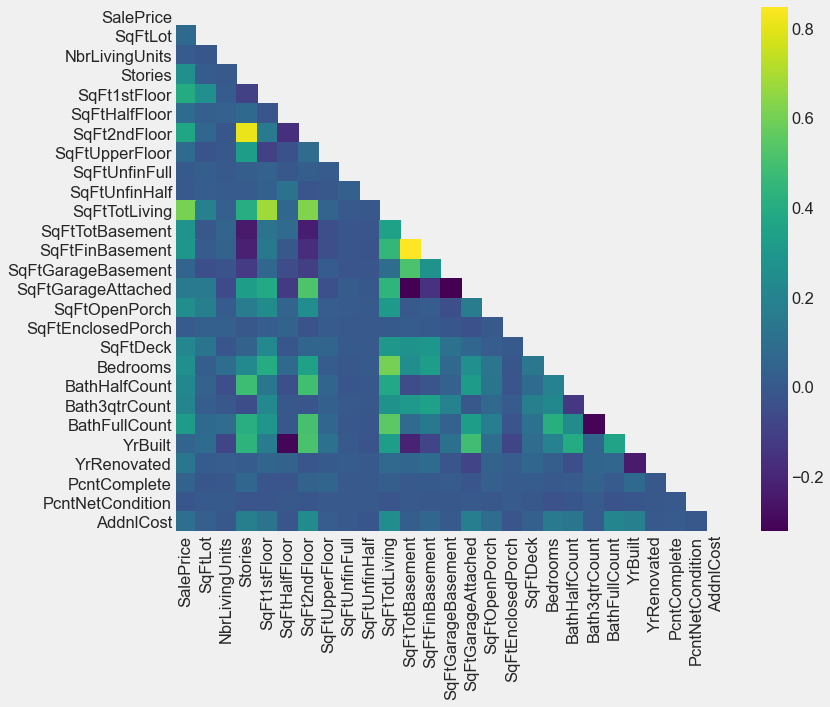

In [123]:
vz.heat_map(corr)

### `SqFtTotLiving` Looks Most Correlated
Confirming and printing a sorted list of correlation magnitudes

In [124]:
# creating a sorted list of correlations
np.abs(corr.SalePrice).sort_values(ascending=False).iloc[1:]

SqFtTotLiving         0.609454
SqFt1stFloor          0.392227
SqFt2ndFloor          0.370389
BathFullCount         0.318210
SqFtFinBasement       0.292734
SqFtTotBasement       0.277310
Stories               0.260426
Bedrooms              0.253457
SqFtOpenPorch         0.249485
BathHalfCount         0.225802
SqFtDeck              0.214524
Bath3qtrCount         0.209274
SqFtGarageAttached    0.156516
YrRenovated           0.136423
AddnlCost             0.097212
SqFtHalfFloor         0.080449
SqFtUpperFloor        0.076565
SqFtLot               0.074803
YrBuilt               0.051285
SqFtGarageBasement    0.049425
PcntComplete          0.039122
NbrLivingUnits        0.009062
PcntNetCondition      0.008201
SqFtEnclosedPorch     0.008199
SqFtUnfinFull         0.002262
SqFtUnfinHalf         0.000483
Name: SalePrice, dtype: float64

### Pair Plot For The Top Four Predictors

In [125]:
# collecting the top five predictors and forming data frame
li = ['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor', 'SqFt2ndFloor',\
      'BathFullCount']

four_most_correlated = df[li]

In [126]:
four_most_correlated.head()

,SalePrice,SqFtTotLiving,SqFt1stFloor,SqFt2ndFloor,BathFullCount
5,560000.0,1930,1930,0,2
6,435000.0,1975,1057,918,1
94,1255000.0,2680,1760,0,1
105,380000.0,1750,920,0,1
144,930000.0,2580,1780,0,2


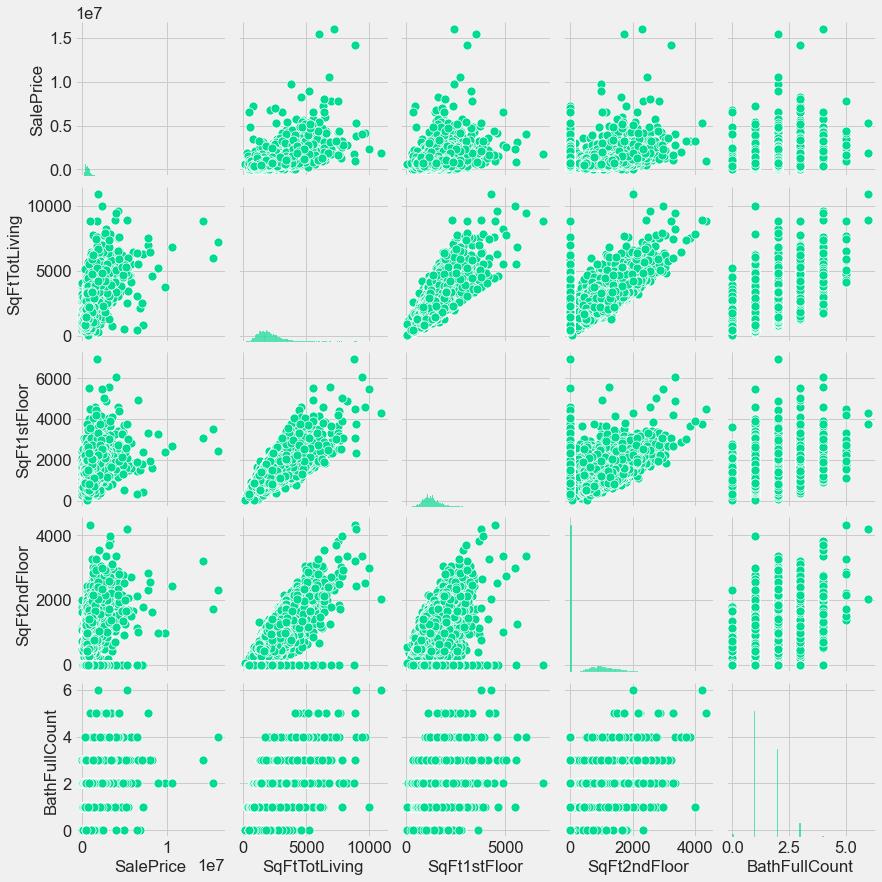

In [127]:
# printing the pairplot
sns.pairplot(four_most_correlated);

The pair plot confirms the linear relationship between `SqFtTotLiving` and `SalePrice`. `SqFtTotLiving` is also highly correlated to the other predictors as well.

# Model 1: Baseline
Creating the first simple model using `SqFtTotLiving` as the predictor.

#### Data Frame

In [128]:
fsm_df = df[['SalePrice', 'SqFtTotLiving']].copy()

#### Model

In [129]:
fsm = ols(formula="SalePrice ~ SqFtTotLiving", data=fsm_df)
fsm_results = fsm.fit()

## Model Results: R-Squared = .371

In [130]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     9644.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:24   Log-Likelihood:            -2.3609e+05
No. Observations:               16323   AIC:                         4.722e+05
Df Residuals:                   16321   BIC:                         4.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.239e+04   8798.112     -1.408      0.159   -2.96e+04    4857.279
SqFtTotLiving   378.4219      3.853     98.206      0.000     370.869     385.975
==============================================================================
Omnibus:                    21907.178   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13486307.854
Skew:                           7.274   Prob(JB):                         0.00
Kurtosis:                     143.063   Cond. No.                     5.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation of Results
Our coefficient indicates that for every square foot increase in `SqFtTotLiving`, `SalePrice` will increase by \$378.42.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [131]:
fn.rainbow(fsm_results)

Rainbow statistic: 0.859061271344214
Rainbow p-value: 0.999999999996513


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the feature. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

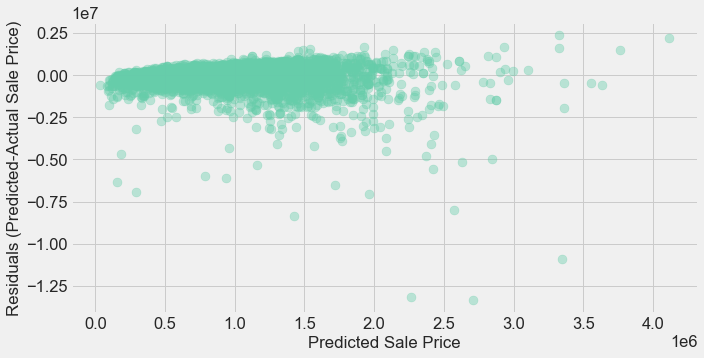

In [132]:
vz.error_plot(fsm_df, 'SalePrice', fsm_results)

#### Result: Fail

We can see from the quantity of dots well below zero, there are more extreme under-prediction than over-predictions. Further, it appears that the over-predictions increase as the predicted price increases.

### Bruesch-Pagan Test

In [133]:
fn.bp_test(fsm_df, 'SalePrice', fsm_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 1.2835676028594985e-74


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor. This result is in line the plot of the residuals.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Bottom Line on the Results

While the coefficient of determination is decent at .37, it appears that there are some problems with the intercept. The p-value of .15, which is above our alpha of .05, means that the value is not statisitically significant, and the confidence interval given is nonsensical.

# Inspecting the Target and Predictor More Closely
Checking the basic stats, and visualiztions for the target and predictor.

## Basic Statistics

In [134]:
# checking statistics for sale price
print(df['SalePrice'].describe())
# checking statistics for sale price
df['SqFtTotLiving'].describe()

count    1.632300e+04
mean     7.750344e+05
std      5.836287e+05
min      1.000000e+01
25%      4.570000e+05
50%      6.458650e+05
75%      8.850000e+05
max      1.605000e+07
Name: SalePrice, dtype: float64


count    16323.000000
mean      2080.805428
std        939.941911
min        116.000000
25%       1420.000000
50%       1920.000000
75%       2530.000000
max      10910.000000
Name: SqFtTotLiving, dtype: float64

## Basic Visualizations

Checking the distribution, linearity, and outliers.

### Histograms

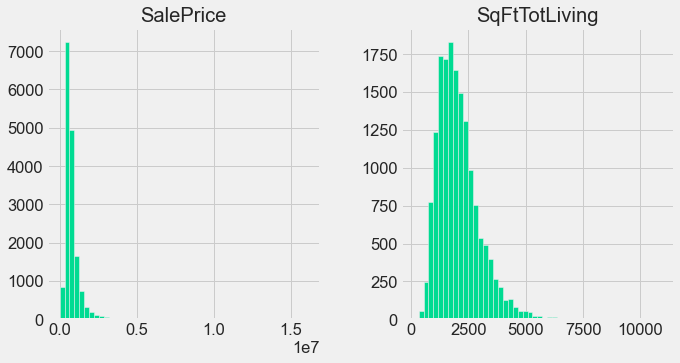

In [135]:
fsm_df.hist(bins=50, figsize=(10,5));

#### Results

Both variables have a strong rightward skew, indicating extreme outliers to the right of the distribution. Dropping outliers and/or a log transformation may be in order.

### Scatterplot

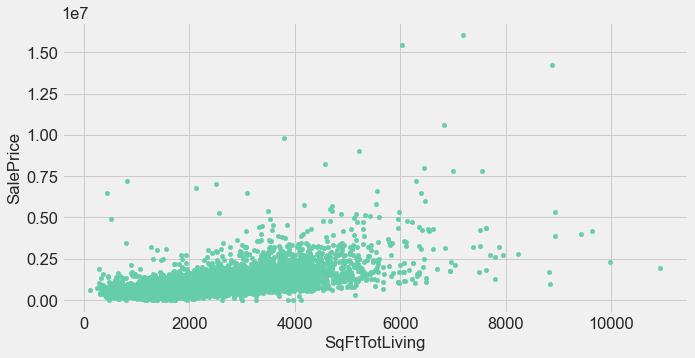

In [136]:
fsm_df.plot.scatter(x='SqFtTotLiving', y='SalePrice',\
                    figsize=(10,5), color='mediumaquamarine');

#### Results

The data exhibits a fairly linear relationship, with the sale price generally rising with square footage. Also, observing the change in density of the data points, it appears that the vast majority of homes are below 5,500 sq. ft. 

### Boxplot

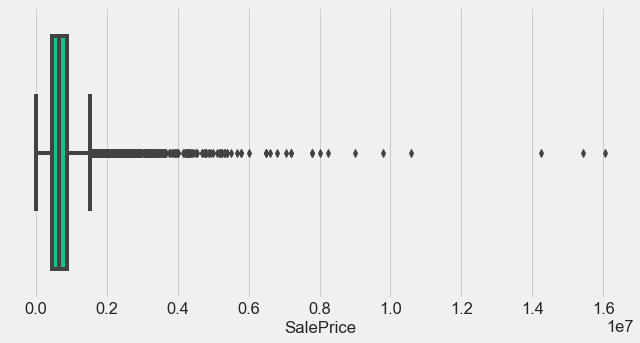

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=df['SalePrice']);

#### Results
From the plot we can see the heavy presence of outliers on the right-hand side of the distribution.

# Removing Outliers
Checking if we can improve the coefficient of determination or the results our assumption tests by getting rid of the outliers in the data using the IQR fences method.

## Calculating Quartiles & IQR of `SalePrice`

In [138]:
# calculating Q1, Q3 and IQR
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
IQR

428000.0

## Statistics of the Outliers

In [139]:
# checking the Stats of the outliers
df[((df['SalePrice'] < (Q1 - 1.5 * IQR))\
     | (df['SalePrice'] > (Q3 + 1.5 * IQR)))]['SalePrice'].describe()

count    1.013000e+03
mean     2.377000e+06
std      1.245990e+06
min      1.530000e+06
25%      1.709000e+06
50%      1.995000e+06
75%      2.588000e+06
max      1.605000e+07
Name: SalePrice, dtype: float64

### Results

All of the outliers are on the right. The minimum value of the outliers is well above the median and mean of the model data set, which is in line with the boxplot above.

## Creating No Outliers Data Frame
Removing outliers, checking shape, and statistics.

In [140]:
no_outliers = df[~((df['SalePrice'] < (Q1 - 1.5 * IQR))\
                   | (df['SalePrice'] > (Q3 + 1.5 * IQR)))].copy()

In [141]:
no_outliers.head()

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,PropType,DistrictName,SqFtLot,WaterSystem,...,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean
5,560000.0,2130430120,3027422,2019-12-20,11,6,R,DUVALL,10523,2,...,0,1989,0,0,0,0,3,0,2019,98019
6,435000.0,9406520630,3002257,2019-07-22,11,6,R,MAPLE VALLEY,7392,2,...,0,1994,0,0,0,0,3,2500,2019,98038
94,1255000.0,3459600230,3020690,2019-10-30,11,6,R,BELLEVUE,10500,2,...,1,1978,0,0,0,0,5,0,2019,98006
105,380000.0,0302000645,2976405,2019-03-04,11,6,R,AUBURN,45303,2,...,1,1963,0,0,0,0,2,0,2019,98001
144,930000.0,0826079096,2997972,2019-06-28,11,6,R,KING COUNTY,212911,1,...,0,1992,0,0,0,0,3,0,2019,98019


In [142]:
print(df['SalePrice'].describe())
no_outliers['SalePrice'].describe()

count    1.632300e+04
mean     7.750344e+05
std      5.836287e+05
min      1.000000e+01
25%      4.570000e+05
50%      6.458650e+05
75%      8.850000e+05
max      1.605000e+07
Name: SalePrice, dtype: float64


count    1.531000e+04
mean     6.690389e+05
std      2.819329e+05
min      1.000000e+01
25%      4.499500e+05
50%      6.200000e+05
75%      8.300000e+05
max      1.526000e+06
Name: SalePrice, dtype: float64

#### Results
We've lost around 1,0000 datapoints, brought the mean down by around \$100,000 and cut out standard deviation in half.

## Visualizations

### Boxplot

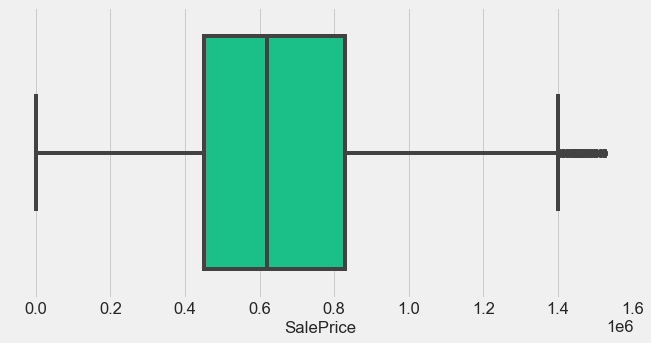

In [143]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=no_outliers['SalePrice']);

#### Results
While there are still outliers present, the data seem to be more symmetrically distributed now.

### Histograms

#### Results
`SalePrice` is looking more normal but still has a heavier tail on the right.

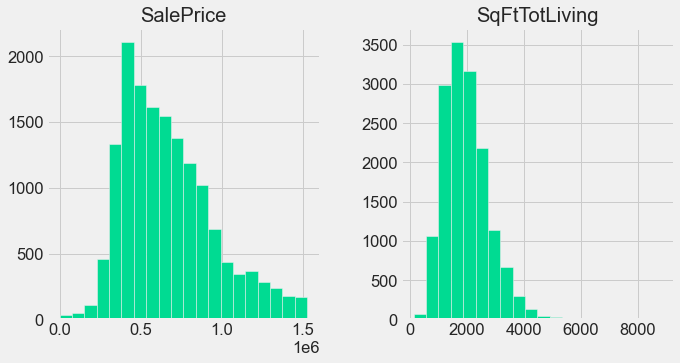

In [144]:
no_outliers[['SalePrice', 'SqFtTotLiving']].hist(bins=20, figsize=(10,5));

### Scatterpolt

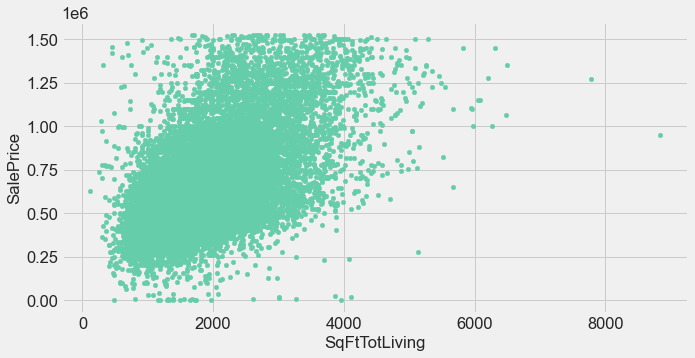

In [145]:
no_outliers[['SalePrice',\
             'SqFtTotLiving']].plot.scatter(x='SqFtTotLiving',\
                                            y='SalePrice', figsize=(10,5), color='mediumaquamarine');

#### Results
The linearity in the data is more pronounced now. There appears to be a cluster of very low value sales that may need to be investigated later in the modeling process.

# Model 2: Outliers Dropped

#### Dataframe

In [146]:
model2_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Model

In [147]:
model2 = ols(formula="SalePrice ~ SqFtTotLiving", data=model2_df)
model2_results = model2.fit()

### Model Result: R-Squared = .293

In [148]:
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     6335.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:27   Log-Likelihood:            -2.1120e+05
No. Observations:               15310   AIC:                         4.224e+05
Df Residuals:                   15308   BIC:                         4.224e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.854e+05   5187.217     55.017      0.000    2.75e+05    2.96e+05
SqFtTotLiving   195.4224      2.455     79.593      0.000     190.610     200.235
==============================================================================
Omnibus:                      893.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1094.863
Skew:                           0.588   Prob(JB):                    1.79e-238
Kurtosis:                       3.578   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation of Results
Our coefficient indicates that for every square foot increase in `SqFtTotLiving`, `SalePrice` will increase by \$195.42.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [149]:
fn.rainbow(model2_results)

Rainbow statistic: 0.9600444347813364
Rainbow p-value: 0.9627522151535642


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis. The model is linearly predicted by the features. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is no longer 0.00, but it is still very small which indicates that the residuals are not normally distributed. The model stil violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

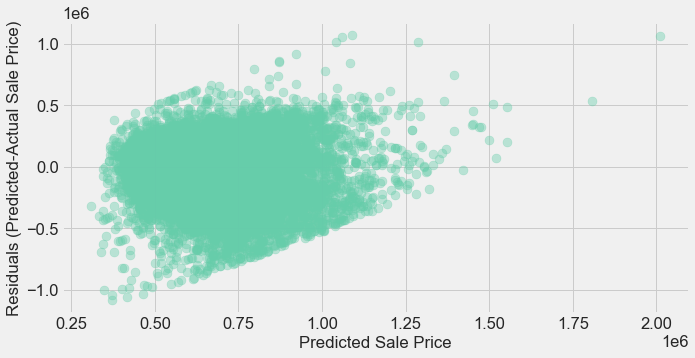

In [150]:
vz.error_plot(model2_df, 'SalePrice', model2_results)

#### Result: Fail
While the residuals have improved somewhat, hetroscadasicity is still present in the graph, with under predictions predominating at lower predicted prices and overpredictions at higher predicted prices.

### Bruesch-Pagan Test

In [151]:
fn.bp_test(model2_df, 'SalePrice', model2_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Bottom Line on the Results
While our r-squared actually decreased from .371 to .293, the coefficients are now both statistically valid now, and the confidence intervals make sense. The residuals look somewhat better as well. Dropping the outliers has improved the model overall. Still some possible numerical problems as indicated by the condition number.

# Model 3: Log-Transforming the Predictor

#### Data Frame

In [152]:
model3_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Transform

In [153]:
model3_df['SqFtTotLiving_log'] = np.log(model3_df['SqFtTotLiving'])

In [154]:
model3_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [155]:
# checking work
model3_df.head(2)

,SalePrice,SqFtTotLiving_log
5,560000.0,7.565275
6,435000.0,7.588324


#### Model

In [156]:
model3 = ols(formula="SalePrice ~ SqFtTotLiving_log", data=model3_df)
model3_results = model3.fit()

### Model Result: R-Squared = .268

In [157]:
model3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     5597.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:28   Log-Likelihood:            -2.1147e+05
No. Observations:               15310   AIC:                         4.229e+05
Df Residuals:                   15308   BIC:                         4.230e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.031e+06   3.61e+04    -56.193      0.000    -2.1e+06   -1.96e+06
SqFtTotLiving_log  3.599e+05   4810.256     74.811      0.000     3.5e+05    3.69e+05
==============================================================================
Omnibus:                      987.474   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1210.670
Skew:                           0.636   Prob(JB):                    1.28e-263
Kurtosis:                       3.531   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
fn.log_interpret(model3_results, ['SqFtTotLiving_log'], .01 )

3580.72


#### Interpretation of Results
For every 1% increase in `SqFtTotLiving`, `SalePrice` will increase by \$3580.72. Since the predictor was log-transformed, an inverse-transform was applied to the coefficient. 

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [159]:
fn.rainbow(model3_results)

Rainbow statistic: 0.9673656150009675
Rainbow p-value: 0.9266488952781328


#### Result: Pass

Since the p-value was greater than .05, we fail to reject the null hypothesis. The model is linearly predicted by the feature. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
P-value is still close to zero,  indicating the model still violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

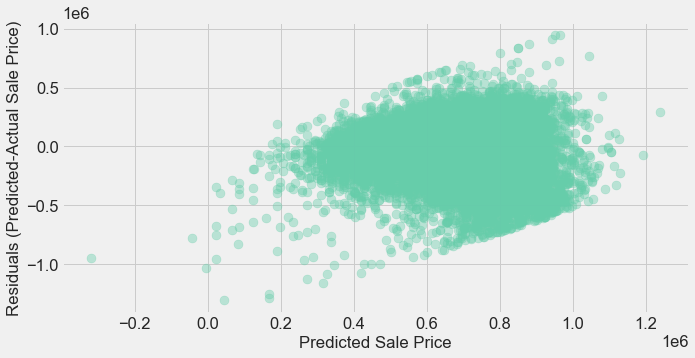

In [160]:
vz.error_plot(model3_df, 'SalePrice', model3_results)

#### Result: Fail
The hetroscadasicity is still pronounced in the graph, with under predictions predominating at lower predicted prices and overpredictions at higher predicted prices.

### Bruesch-Pagan Test

In [161]:
fn.bp_test(model3_df,'SalePrice',model3_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result: Fail
The p-value of 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Bottom Line on the Results
While our r-squared again decreased from .293 to .268, the coefficients are statistically significant, the cofidence intervals are good and the condition number warning is gone. Logging the predictor has improved the model overall.

## Visualizations
Checking how things have changed with logging the predictor.

### Boxplot

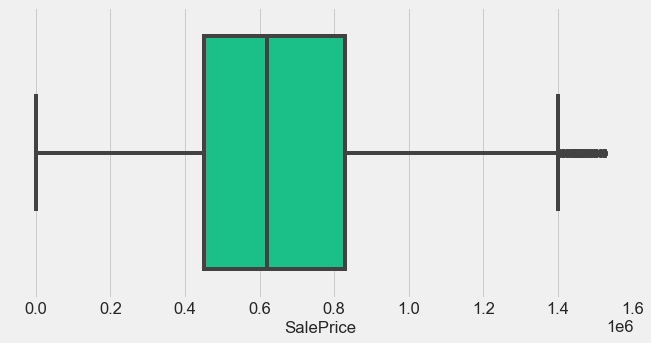

In [162]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=model3_df['SalePrice']);

#### Results
While there are still outliers present, the data seem to be more symmetrically distributed now.

### Histograms

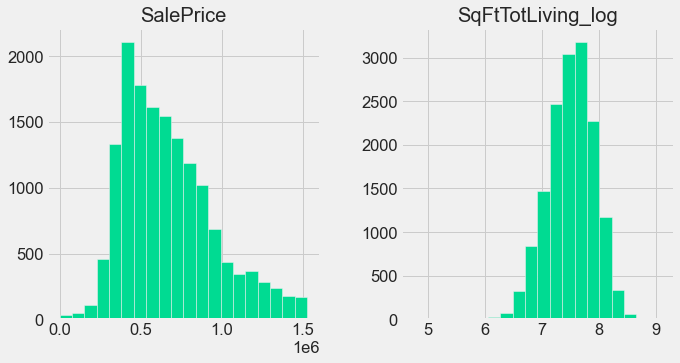

In [163]:
model3_df[['SalePrice', 'SqFtTotLiving_log']].hist(bins=20, figsize=(10,5));

#### Results
`SalePrice` is unchanged from Model 2, but `SqFtTotLiving_log` is looking more normal and now has bigger tail on the left.

### Scatterpolt

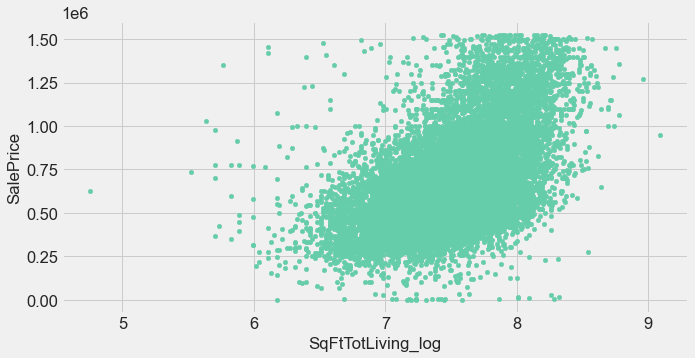

In [164]:
model3_df.plot.scatter(x='SqFtTotLiving_log',\
                       y='SalePrice', figsize=(10,5), color='mediumaquamarine');

#### Results
The linearity in the data is still there; However, after the transformation it looks like a higher degree polynomial might be a better fit.

# Model 4: Log-Transforming the Target

#### Data Frame

In [165]:
model4_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Log-Transform `SalePrice`

In [166]:
model4_df['SalePrice_log'] = np.log(model4_df['SalePrice'])

In [167]:
model4_df.drop('SalePrice', axis=1, inplace=True)

In [168]:
# checking work
model4_df.head(1)

,SqFtTotLiving,SalePrice_log
5,1930,13.235692


#### Model

In [169]:
model4 = ols(formula="SalePrice_log ~ SqFtTotLiving", data=model4_df)
model4_results = model4.fit()

### Model Result: R-Squared = .219

In [170]:
model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     4295.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:30   Log-Likelihood:                -8638.7
No. Observations:               15310   AIC:                         1.728e+04
Df Residuals:                   15308   BIC:                         1.730e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.7521      0.009   1370.146      0.000      12.734      12.770
SqFtTotLiving     0.0003   4.41e-06     65.536      0.000       0.000       0.000
==============================================================================
Omnibus:                    14744.256   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2683755.888
Skew:                          -4.193   Prob(JB):                         0.00
Kurtosis:                      67.318   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [171]:
fn.log_target(model4_results, ['SqFtTotLiving'])

0.0289


#### Interpretation of the Results
For every square foot increase in `SqFtTotLiving` the `SalePrice` will increase by .0289%.

## Checking Linear Regression Assumptions

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [172]:
fn.rainbow(model4_results)

Rainbow statistic: 1.0701535821804544
Rainbow p-value: 0.0015108441067721815


#### Result: Fail

Since the p-value is below .05, we reject the null hypothesis. The model is not linearly predicted by the features. 

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is  0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

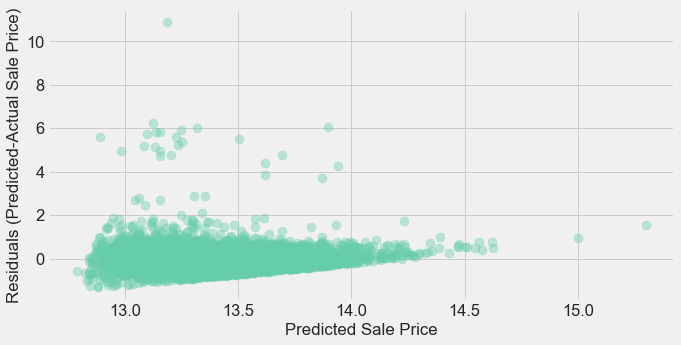

In [173]:
vz.error_plot(model4_df, 'SalePrice_log', model4_results)

#### Result: Fail
Given the wedge shape of the points, hetroscadasicity is clearly visible in the graph.

### Bruesch-Pagan Test

In [174]:
fn.bp_test(model4_df,'SalePrice_log',model4_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 5.453905345232404e-39


#### Result: Fail
The p-value close to 0 indicates that we must reject the null hypothesis and conclude that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Result: N/A
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Bottom Line on the Results
R-squared decreased from .268 to .219, the coefficients and confidence intervals are still valid, but the condition number warning is back. The linearity assumption has be broken, and hetroscadasicity worsened as well. Transforming the target has reduced the quality of the model overall.

# Model 5: Log-Transforming Both the Target and the Predictor

#### Data Frame

In [175]:
model5_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Transformation

In [176]:
fn.logger(model5_df,['SalePrice', 'SqFtTotLiving'])

In [177]:
model5_df.drop(['SalePrice', 'SqFtTotLiving'], axis=1, inplace=True)

In [178]:
# checking results
model5_df.head(1)

,SalePrice_log,SqFtTotLiving_log
5,13.235692,7.565275


#### Model

In [179]:
model5 = ols(formula="SalePrice_log ~ SqFtTotLiving_log", data=model5_df)
model5_results = model5.fit()

### Model Result: R-Squared = .216

In [180]:
model5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     4216.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:31   Log-Likelihood:                -8669.5
No. Observations:               15310   AIC:                         1.734e+04
Df Residuals:                   15308   BIC:                         1.736e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.1780      0.064    143.703      0.000       9.053       9.303
SqFtTotLiving_log     0.5519      0.008     64.932      0.000       0.535       0.569
==============================================================================
Omnibus:                    14569.884   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2622347.173
Skew:                          -4.108   Prob(JB):                         0.00
Kurtosis:                      66.587   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
fn.log_all(model5_results, ['SqFtTotLiving_log'], .01)

0.5506


#### Interpreting the Results
For every 1% increase in `SqFtTotLiving` , `SalePrice` will increase by .5506%.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [182]:
fn.rainbow(model5_results)

Rainbow statistic: 1.0761284130837812
Rainbow p-value: 0.0006660194963169775


#### Result: Fail

Failure of linearity. P-value is much less than .05.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is  0.00, so the model still violates the normality assumption for linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

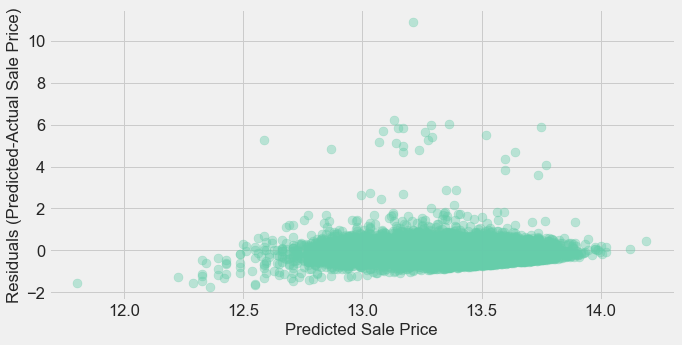

In [183]:
vz.error_plot(model5_df, 'SalePrice_log', model5_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions abundant in the middle range.

### Bruesch-Pagan Test

In [184]:
fn.bp_test(model5_df,'SalePrice_log',model5_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 3.8957409402003895e-51


#### Result:Fail
The p-value close to 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

#### Results
Skipping this for now, the model only has one predictor, so it is by independent by definition.

## Bottom Line the Results
R-squared decreased slightly from .219 to .216, and the coefficients and CIs are still valid. The condition number warning number is gone again, but still failing Jarque_Bera and hetroscadasicity checks.

# Result From Initial Models: Model 3 Performed Best (R-Sq.=.268)
Will use Model 3 as the basis for moving forward. It had the best combination of r-squared and adherence to linear regression assumptions.

# Model 6: Adding `SqFt1stFloor` Feature
Adding another continuous feature to the model.

#### Data Frame

In [185]:
model6_df = no_outliers[['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']].copy()

#### Log Transform `SqFtTotLiving`

In [186]:
fn.logger(model6_df, ['SqFtTotLiving'])

In [187]:
model6_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [188]:
# checking work
model6_df.head(1)

,SalePrice,SqFt1stFloor,SqFtTotLiving_log
5,560000.0,1930,7.565275


#### Formula

In [189]:
formula = "SalePrice ~ SqFtTotLiving_log + SqFt1stFloor"

In [190]:
model6 = ols(formula, data=model6_df)

In [191]:
model6_results = model6.fit();

### Model Result: R-Squared = .270

In [192]:
model6_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     2828.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:32   Log-Likelihood:            -2.1145e+05
No. Observations:               15310   AIC:                         4.229e+05
Df Residuals:                   15307   BIC:                         4.229e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.166e+06   4.14e+04    -52.323      0.000   -2.25e+06   -2.08e+06
SqFtTotLiving_log  3.841e+05   6030.249     63.697      0.000    3.72e+05    3.96e+05
SqFt1stFloor        -37.7852      5.680     -6.652      0.000     -48.919     -26.652
==============================================================================
Omnibus:                     1008.360   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.989
Skew:                           0.641   Prob(JB):                    7.43e-271
Kurtosis:                       3.552   Cond. No.                     2.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
fn.log_interpret(model6_results, ['SqFtTotLiving_log'], .01)

3822.03


#### Interpreting the Results
While holding `SqFt1stFloor` constant, every 1% increase in `SqFtTotLiving` will increase `SalePrice` by \$3822.03. Conversely, if `SqFtTotLiving` is held constant, for every square foot increase in `SqFt1stFloor`, `SalePrice` will decrease by \$37.79.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [194]:
fn.rainbow(model6_results)

Rainbow statistic: 0.9651685343651406
Rainbow p-value: 0.9395110814138893


#### Result: Pass

Linearity in the model is back. The test p-value is much greater than .05.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

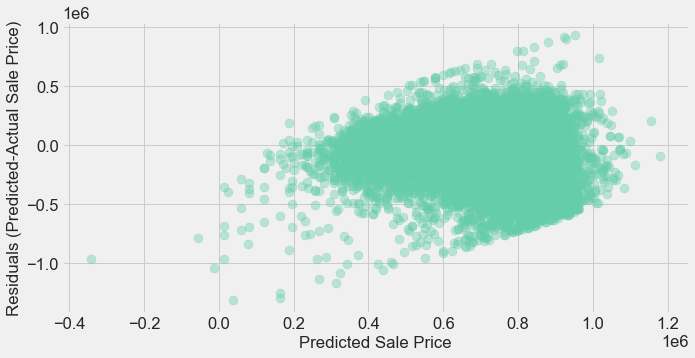

In [195]:
vz.error_plot(model6_df, 'SalePrice', model6_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [196]:
fn.bp_test(model6_df,'SalePrice',model6_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [197]:
fn.vif(model6_df)

,VIF,feature
0,11.270075,SqFt1stFloor
1,11.270075,SqFtTotLiving_log


#### Result: Fail
The VIF value for both coefficients is above 5, indicating that there is multicollinearity in the features.

## Bottom Line on the Results
R-squared increased slightly from .268 to .270, and the coefficients and CIs are still valid. Hetroscadasicity is better than model5, but still bad. The condition number warning number is back again and the VIF numbers indicate multicollinearity in the features.

# Model 7 Log-Scaling `SqFt1stFloor` Feature
Checking to see if we can get the improve any of our assumption checks by scaling the new feature.

#### Data Frame

In [198]:
model7_df = no_outliers[['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']].copy()

#### Log Transform `SqFtTotLiving` & `SqFt1stFloor`

In [199]:
fn.logger(model7_df, ['SqFtTotLiving', 'SqFt1stFloor'])

In [200]:
# checking work
model7_df.drop(['SqFtTotLiving', 'SqFt1stFloor'], axis=1, inplace=True)
model7_df.head(1)

,SalePrice,SqFtTotLiving_log,SqFt1stFloor_log
5,560000.0,7.565275,7.565275


#### Formula

In [201]:
formula = "SalePrice ~ SqFtTotLiving_log + SqFt1stFloor_log"

#### Model

In [202]:
model7 = ols(formula, data=model7_df)

In [203]:
model7_results = model7.fit();

### Model Result: R-Squared = .276

In [204]:
model7_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     2920.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:33   Log-Likelihood:            -2.1138e+05
No. Observations:               15310   AIC:                         4.228e+05
Df Residuals:                   15307   BIC:                         4.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.741e+06    4.2e+04    -41.429      0.000   -1.82e+06   -1.66e+06
SqFtTotLiving_log  4.098e+05   6072.545     67.477      0.000    3.98e+05    4.22e+05
SqFt1stFloor_log  -9.402e+04   7050.045    -13.335      0.000   -1.08e+05   -8.02e+04
==============================================================================
Omnibus:                      996.523   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1227.575
Skew:                           0.636   Prob(JB):                    2.73e-267
Kurtosis:                       3.552   Cond. No.                         226.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [205]:
fn.log_interpret(model7_results, ['SqFtTotLiving_log', 'SqFt1stFloor_log'], .01)

4077.24
-935.49


#### Interpreting the Results
While holding `SqFt1stFloor` constant, every 1% increase in `SqFtTotLiving` will increase `SalePrice` by \$4077.24. Conversely, if `SqFtTotLiving` is held constant, for every 1% increase increase in `SqFt1stFloor`, `SalePrice` will decrease by \$935.49.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [206]:
fn.rainbow(model7_results)

Rainbow statistic: 0.9616931902969964
Rainbow p-value: 0.9562238598999079


#### Result: Pass

The test p-value is much greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

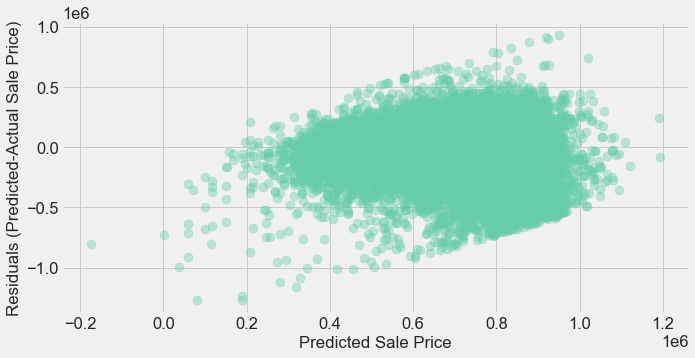

In [207]:
vz.error_plot(model7_df,'SalePrice',model7_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [208]:
fn.bp_test(model7_df,'SalePrice',model7_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [209]:
fn.vif(model7_df)

,VIF,feature
0,484.799614,SqFtTotLiving_log
1,484.799614,SqFt1stFloor_log


#### Result: Fail
The VIF values for both coefficients are far above 5, indicating that there is strong multicollinearity in the features.

## Bottom Line on the Results
R-squared increased from .270 to .276, and the coefficients and CIs are still valid. However, the condition number warning number is back again, Jarque_Bera p-value is still close to zero, and the VIF numbers have exploded. Removing SqFt1stFloor_log feature.

# Model 8: Adding `BathFullCount` Feature
Testing `BathFullCount` as a categorical feature.

#### Data Frame

In [210]:
initial8 = no_outliers[['SalePrice', 'SqFtTotLiving', 'BathFullCount']].copy()

#### Log Transform `SqFtTotLiving`

In [211]:
fn.logger(initial8, ['SqFtTotLiving'])

In [212]:
initial8_logged = initial8.drop('SqFtTotLiving', axis=1)

In [213]:
# checking work
initial8_logged.head(1)

,SalePrice,BathFullCount,SqFtTotLiving_log
5,560000.0,2,7.565275


#### Checking Categories

In [214]:
initial8_logged['BathFullCount'].unique()

array([2, 1, 3, 4, 0, 5])

### One-Hot Encoding The Categories
Encoding, creating a categorical dataframe, and dropping the feature from the initial dataframe.

In [215]:
transformed = fn.one_hot(initial8_logged, 'BathFullCount')

In [216]:
# creating heat_ohe data frame and checking the first few columns
bath_ohe = pd.DataFrame(transformed[1].todense(),\
                       columns = transformed[0].get_feature_names())
bath_ohe.head(1)

,x0_1,x0_2,x0_3,x0_4,x0_5
0,0.0,1.0,0.0,0.0,0.0


In [217]:
dropped8 = initial8_logged.drop('BathFullCount', axis=1)
dropped8.reset_index(inplace=True, drop=True)

### Creating `model8_df` Data Frame

In [218]:
# creating the model dataframe and checking first few rows
model8_df = pd.concat([dropped8, bath_ohe], axis=1)
model8_df.head(3)

,SalePrice,SqFtTotLiving_log,x0_1,x0_2,x0_3,x0_4,x0_5
0,560000.0,7.565275,0.0,1.0,0.0,0.0,0.0
1,435000.0,7.588324,1.0,0.0,0.0,0.0,0.0
2,1255000.0,7.893572,1.0,0.0,0.0,0.0,0.0


#### Creating the Model Formula

In [219]:
formula = fn.create_formula("SalePrice", model8_df)

#### Creating and Fitting the Model

In [220]:
model8 = ols(formula, data=model8_df)

In [221]:
model8_results = model8.fit();

#### Model Result: R-Squared = .273

In [222]:
model8_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     959.2
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:34   Log-Likelihood:            -2.1141e+05
No. Observations:               15310   AIC:                         4.228e+05
Df Residuals:                   15303   BIC:                         4.229e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.921e+06   4.25e+04    -45.245      0.000      -2e+06   -1.84e+06
SqFtTotLiving_log  3.618e+05   5557.319     65.104      0.000    3.51e+05    3.73e+05
x0_1              -1.252e+05   1.72e+04     -7.271      0.000   -1.59e+05   -9.14e+04
x0_2              -1.369e+05   1.76e+04     -7.763      0.000   -1.71e+05   -1.02e+05
x0_3              -6.414e+04   1.98e+04     -3.233      0.001   -1.03e+05   -2.52e+04
x0_4              -8.775e+04   3.92e+04     -2.239      0.025   -1.65e+05   -1.09e+04
x0_5              -4.165e+05   2.41e+05     -1.726      0.084   -8.89e+05    5.64e+04
==============================================================================
Omnibus:                      927.165   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.765
Skew:                           0.616   Prob(JB):                    4.25e-244
Kurtosis:                       3.490   Cond. No.                         945.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
fn.log_interpret(model8_results, ['SqFtTotLiving_log'], .01)

3600.05


#### Interpreting the Results
By dropping the category of zero bathrooms, we integrated it into the intercept term. Since the coefficients of the other bathroom categories are less negative than the intercept, they indicate that when holding `SqFtTotLiving` constant, homes with more than 0 bathrooms will have higher sale prices to varying degrees. Conversely, when holding all other features constant, the coefficient for SqFtTotLiving_log suggests that every 1% increase in SqFtTotLiving will increase `SalePrice` by \$3600.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [224]:
fn.rainbow(model8_results)

Rainbow statistic: 0.9675094512552906
Rainbow p-value: 0.9257071123841183


#### Result: Pass

The test p-value is much greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

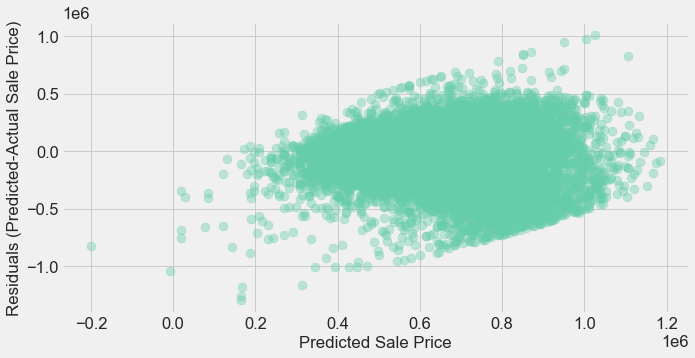

In [225]:
vz.error_plot(model8_df, 'SalePrice', model8_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [226]:
fn.bp_test(model8_df, 'SalePrice', model8_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [227]:
fn.vif(model8_df)

,VIF,feature
0,73.337917,SqFtTotLiving_log
1,40.387554,x0_1
2,29.801803,x0_2
3,4.866617,x0_3
4,1.274939,x0_4
5,1.007003,x0_5


#### Result: Fail
The VIF values multiple coefficients are above 10, indicating that there is strong multicollinearity in the features.

#### Bottom Line on the Results
R-squared decreased slightly from .276 to .273, and the coefficients and CIs are problematic for some of the predictors. The condition number warning number is gone, but there are large VIF present indicating that there is strong multicollinearity in the features. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. Dropping the `BathFullCount` feature from the model.

# Write Up Model 9 Results

## Model 9: Adding `HeatSystem` Feature

### HeatSystem Dataframe

In [228]:
heat_df = no_outliers[['SalePrice','SqFtTotLiving', 'HeatSystem']].copy()
heat_df.head(3)

,SalePrice,SqFtTotLiving,HeatSystem
5,560000.0,1930,5
6,435000.0,1975,5
94,1255000.0,2680,5


### Logging `SqFtTotLiving`

In [229]:
fn.logger(heat_df, ['SqFtTotLiving'])

In [230]:
heat_logged = heat_df.drop('SqFtTotLiving', axis=1)

In [231]:
# checking NaNs
heat_logged.head(1)

,SalePrice,HeatSystem,SqFtTotLiving_log
5,560000.0,5,7.565275


#### Prepping for Model Data Frame

Creating a dictionary of the lookup code descriptions, and using it to make a list of values for use in a new column.  Will use this column in a one-hot-encoding procedure for more descriptive column names in the model dataframe.

In [232]:
# checking unique values
print(heat_logged.HeatSystem.unique())
fn.print_uniques(heat_logged, ['HeatSystem'])

['5' '4' '1' '7' '3' '6' '2' '8' '0']
HeatSystem:  9


#### Grabbing Lookup Codes

In [233]:
# looking up HeatSystem codes 
lu_df = fn.lookup(look, 108)
lu_df

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Making & Mapping Dictionary of Lookup Codes & Descriptions
Zipping lists of keys and values for dictionary from lookup data frame columns. Creating dictionary and mapping it to the `heat_df` data frame.

In [234]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [235]:
heat_logged.HeatSystem.map(heatnames)

5         Forced Air
6         Forced Air
94        Forced Air
105          Elec BB
144       Forced Air
             ...    
251262    Forced Air
251264    Forced Air
251274       Elec BB
251275    Forced Air
251276    Forced Air
Name: HeatSystem, Length: 15310, dtype: object

In [236]:
heat_logged.reset_index(inplace=True, drop=True)

#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame

In [237]:
heat_logged['HeatNames'] = heat_logged.HeatSystem.map(heatnames)

In [238]:
fn.dropper(heat_logged, 'HeatSystem', True)

#### Checking for `NaN` values and replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [239]:
# checking for NaNs
heat_logged['HeatNames'].isna().sum()

16

In [240]:
# filling NaNs with strings
heat_logged.fillna('NA', inplace=True)

In [241]:
# checking work
heat_logged.isna().sum()

SalePrice            0
SqFtTotLiving_log    0
HeatNames            0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `heat_df[['HeatNames']]` , and transforming the data. Creating a new `heat_ohe` data frame, dropping the `'HeatNames'` column from ` heat_df2`, and concatenating it will `heat_ohe` to form a new `model_df` data frame.

In [242]:
transformed = fn.one_hot(heat_logged, 'HeatNames')

In [243]:
# creating heat_ohe data frame and checking the first few columns
heat_ohe = pd.DataFrame(transformed[1].todense(),\
                       columns = transformed[0].get_feature_names())
heat_ohe.head(1)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [244]:
# dropping the 'HeatNames' column from heat_df
heat_dropped = heat_logged.drop('HeatNames', axis=1)

#### Creating `model_df` Data Frame

In [245]:
# creating the model dataframe and checking first few rows
modelh_df = pd.concat([heat_dropped, heat_ohe], axis=1)
modelh_df.head(2)

,SalePrice,SqFtTotLiving_log,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,7.565275,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,435000.0,7.588324,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cleaning Column Names
Stripping whitespaces and converting hyphens to underscores.

In [246]:
modelh_df.columns = modelh_df.columns.str.replace(' ', '_')

In [247]:
modelh_df.columns = modelh_df.columns.str.replace('-', '_')

In [248]:
modelh_df.columns

Index(['SalePrice', 'SqFtTotLiving_log', 'x0_Floor_Wall', 'x0_Forced_Air',
       'x0_Gravity', 'x0_Heat_Pump', 'x0_Hot_Water', 'x0_NA', 'x0_Other',
       'x0_Radiant'],
      dtype='object')

In [249]:
print(modelh_df.shape)
modelh_df.head(1)

(15310, 10)


,SalePrice,SqFtTotLiving_log,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,7.565275,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating `modelh_df` Correlation List and Heatmap

In [250]:
# printing correlation list
np.abs(modelh_df.corr().SalePrice).sort_values(ascending=False)

SalePrice            1.000000
SqFtTotLiving_log    0.517420
x0_Floor_Wall        0.090259
x0_Forced_Air        0.077061
x0_Heat_Pump         0.074840
x0_Hot_Water         0.063625
x0_Radiant           0.043427
x0_NA                0.018538
x0_Gravity           0.014394
x0_Other             0.001246
Name: SalePrice, dtype: float64

In [251]:
corr = modelh_df.corr()

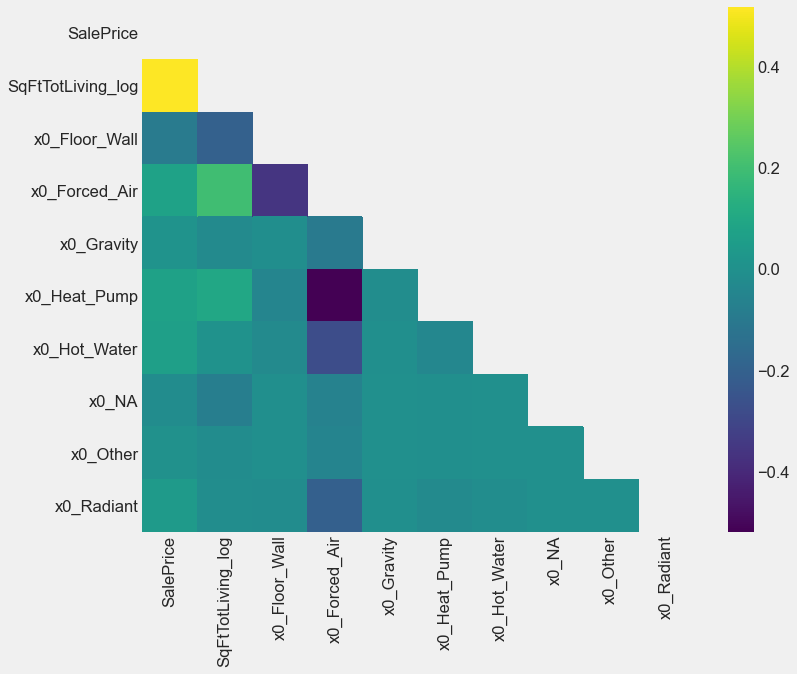

In [252]:
vz.heat_map(corr)

#### Creating Model Formula

In [253]:
formula = fn.create_formula('SalePrice', modelh_df)

#### Model

In [254]:
modelh = ols(formula, data=modelh_df)

In [255]:
modelh_results = modelh.fit();

#### Model Result: R-Squared = .279

In [256]:
modelh_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     656.5
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:37   Log-Likelihood:            -2.1136e+05
No. Observations:               15310   AIC:                         4.227e+05
Df Residuals:                   15300   BIC:                         4.228e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.043e+06   3.71e+04    -55.043      0.000   -2.12e+06   -1.97e+06
SqFtTotLiving_log  3.543e+05   5094.458     69.552      0.000    3.44e+05    3.64e+05
x0_Floor_Wall      7.345e+04   1.29e+04      5.697      0.000    4.82e+04    9.87e+04
x0_Forced_Air      4.998e+04   7667.068      6.519      0.000     3.5e+04     6.5e+04
x0_Gravity         2.161e+05      4e+04      5.400      0.000    1.38e+05    2.94e+05
x0_Heat_Pump       7.914e+04   1.07e+04      7.421      0.000    5.82e+04       1e+05
x0_Hot_Water       1.721e+05   1.57e+04     10.996      0.000    1.41e+05    2.03e+05
x0_NA              2.533e+05   6.04e+04      4.194      0.000    1.35e+05    3.72e+05
x0_Other           1.727e+05   7.61e+04      2.270      0.023    2.36e+04    3.22e+05
x0_Radiant         1.903e+05   2.01e+04      9.463      0.000    1.51e+05     2.3e+05
==============================================================================
Omnibus:                      976.376   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1195.704
Skew:                           0.631   Prob(JB):                    2.27e-260
Kurtosis:                       3.532   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
fn.log_interpret(modelh_results, ['SqFtTotLiving_log'], .01)

3525.68


#### Interpreting the Results
The `ElecBB` heating system category was dropped during encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices relative to homes with `ElecBB` heating when holding `SqFtTotLiving_log` constant. Conversely, when holding the the other features constant, the coefficient for SqFtTotLiving indicates that for every 1% increase in `SqFtTotLiving` will result in a \$3525 increase in `SalePrice`. 

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [258]:
fn.rainbow(modelh_results)

Rainbow statistic: 0.9647069657339358
Rainbow p-value: 0.9419379029545248


#### Result: Pass

The test p-value is greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

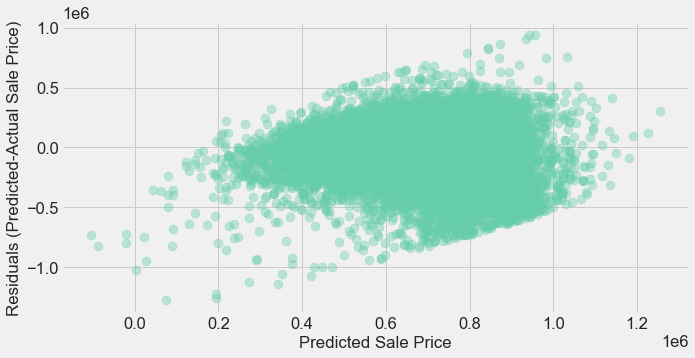

In [259]:
vz.error_plot(modelh_df, 'SalePrice', modelh_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [260]:
fn.bp_test(modelh_df, 'SalePrice', modelh_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [261]:
fn.vif(modelh_df)

,VIF,feature
0,14.209686,SqFtTotLiving_log
1,1.404881,x0_Floor_Wall
2,12.356729,x0_Forced_Air
3,1.032208,x0_Gravity
4,1.968194,x0_Heat_Pump
5,1.279361,x0_Hot_Water
6,1.011055,x0_NA
7,1.008535,x0_Other
8,1.148723,x0_Radiant


#### Result: Fail
The VIF values for the SqFtTotLiving_log and x0_Forced_Air coefficients are above 5, indicating that there is multicollinearity in the features.

#### Bottom Line on the Results
R-squared increased slightly from .273 to .279. The p-values for the coefficients, and CIs are are valid for the predictors. The condition number warning number is gone, but there are large VIF present indicating that there is multicollinearity in the some features. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. Adding the HeatSystems feature has improved the model.


# Model 11: Square-Root Scaling `SqFtTotLiving`
Seeing if we can get some improvement by square-rooting the `SqFtTotLiving` feature.

#### Data Frame

In [262]:
model11_df = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Transform
Square-rooting the predictor.

In [263]:
model11_df['SqFtTotLiving_sqrt'] = np.sqrt(model11_df['SqFtTotLiving'])

In [264]:
model11_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [265]:
# checking work
model11_df.head(2)

,SalePrice,SqFtTotLiving_sqrt
5,560000.0,43.931765
6,435000.0,44.440972


#### Model

In [266]:
model11 = ols(formula="SalePrice ~ SqFtTotLiving_sqrt", data=model11_df)
model11_results = model11.fit()

### Model Result: R-Squared = .287

In [267]:
model11_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6170.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:38   Log-Likelihood:            -2.1126e+05
No. Observations:               15310   AIC:                         4.225e+05
Df Residuals:                   15308   BIC:                         4.225e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -9.182e+04   9875.526     -9.297      0.000   -1.11e+05   -7.25e+04
SqFtTotLiving_sqrt  1.751e+04    222.883     78.549      0.000    1.71e+04    1.79e+04
==============================================================================
Omnibus:                      898.211   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.973
Skew:                           0.599   Prob(JB):                    9.26e-237
Kurtosis:                       3.518   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpreting the Results

Since we square-rooted the `SqFtTotLiving` ( in feet^2 units), the coefficient indicates that for every 1 foot change in total living space the sale price will increase \$17,500.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [268]:
fn.rainbow(model11_results)

Rainbow statistic: 0.9623166690504383
Rainbow p-value: 0.953537001774481


### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

#### Error Plot

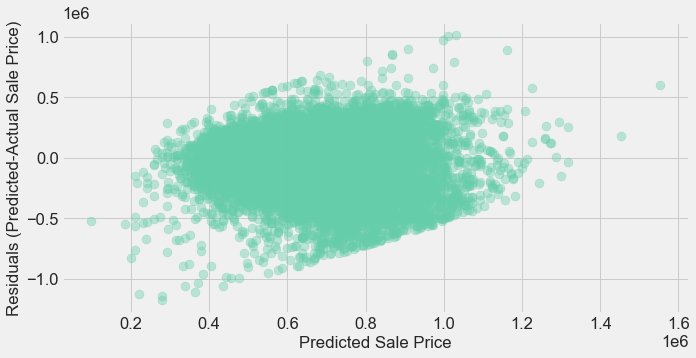

In [269]:
vz.error_plot(model11_df, 'SalePrice', model11_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with under predictions predominating at lower predicted prices and over predictions at higher predicted prices.

### Bruesch-Pagan Test

In [270]:
fn.bp_test(model11_df, 'SalePrice', model11_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

### VIF Test:

Since the model only has one feature, it is independent by definition.

#### Results: N/A

#### Bottom Line on the Results
R-squared increased slightly from .278 to .287. The p-values for the coefficients, and CIs are are valid for the predictor. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. Square-root scaling the `SqFtTotLiving` feature has improved the model.


# EDA: A Deeper Look for Outliers
Looking for ways to improve the model by doing more data exploration and feature engineering. Creating a new data frame, binning `SqFtTotLiving` data, and creating a `PriceSqFt` column.

#### Creating the Data Frame

In [271]:
eda12 = no_outliers[['SalePrice', 'SqFtTotLiving']].copy()

#### Binning the Data and creating `Bins` & `StrBins` columns.

In [272]:
eda12['Bins'] = pd.cut(eda12['SqFtTotLiving'], bins=9)

In [273]:
eda12['StrBins'] = eda12['Bins'].astype(str)

#### Adding `PriceSqFt` Feature
Adding price per square feet column and checking work.

In [274]:
# adding price per square foot column
eda12['PriceSqFt'] = eda12['SalePrice']/eda12['SqFtTotLiving']

In [275]:
eda12.head(2)

,SalePrice,SqFtTotLiving,Bins,StrBins,PriceSqFt
5,560000.0,1930,"(1084.222, 2052.444]","(1084.222, 2052.444]",290.155440
6,435000.0,1975,"(1084.222, 2052.444]","(1084.222, 2052.444]",220.253165


### Visualizing the Data

#### Outliers
We can see that there are high price outliers on the low 'SqFtTotLiving` spectrum.

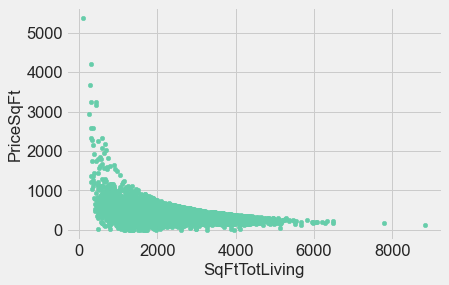

In [276]:
eda12.plot.scatter(x='SqFtTotLiving',\
                   y='PriceSqFt', color='mediumaquamarine');

#### Creating Bins List and Plotting the Low `SqFtTotLiving` Bin
The skewed distribution and outliers are clear in the plots.

In [277]:
# creating a bins list
bin_list = list(set(eda12['Bins']))
bins = sorted(bin_list)

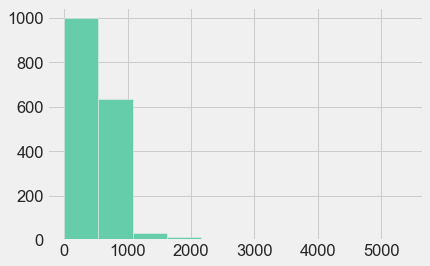

In [278]:
eda12[eda12.Bins == bins[0]]['PriceSqFt'].hist(color='mediumaquamarine');

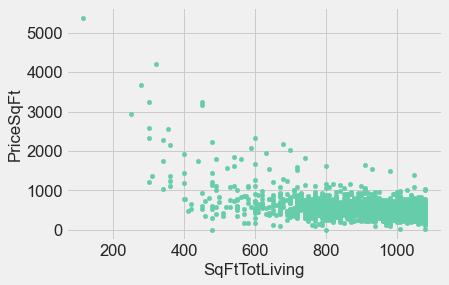

In [279]:
eda12[eda12.Bins == bins[0]].plot.scatter(x='SqFtTotLiving',\
                                          y='PriceSqFt', color='mediumaquamarine');

#### Investigating the Next Bin
It looks a lot more normal in both sense of the word.

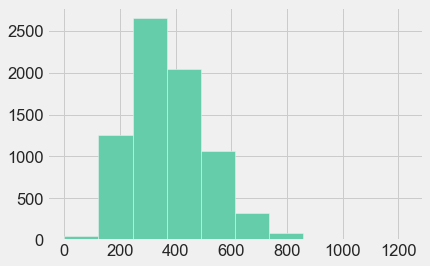

In [280]:
eda12[eda12.Bins == bins[1]]['PriceSqFt'].hist(color='mediumaquamarine');

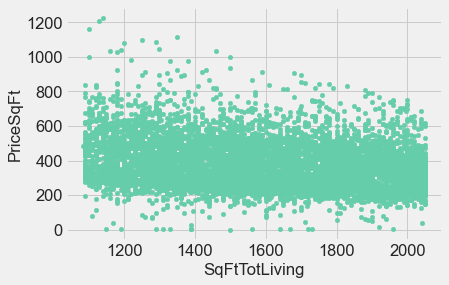

In [281]:
eda12[eda12.Bins == bins[1]].plot.scatter(x='SqFtTotLiving',\
                                          y='PriceSqFt', color='mediumaquamarine');

#### Cheking The Stats of The Bins
We can see that the 1st bin has a much higher price per square foot than the rest of the bins.

In [282]:
eda12.groupby('Bins').describe()

SalePrice                                          \
                         count          mean            std        min   
Bins                                                                     
(107.286, 1084.222]     1699.0  4.652536e+05  190933.180701     1500.0   
(1084.222, 2052.444]    7503.0  5.895970e+05  220190.349988       10.0   
(2052.444, 3020.667]    4640.0  7.704133e+05  272093.006674     3030.0   
(3020.667, 3988.889]    1230.0  9.648419e+05  294978.496618     2540.0   
(3988.889, 4957.111]     194.0  1.120356e+06  286507.128661    16082.0   
(4957.111, 5925.333]      32.0  1.127309e+06  280398.710778   275000.0   
(5925.333, 6893.556]      10.0  1.165700e+06  150197.684551  1000000.0   
(6893.556, 7861.778]       1.0  1.270000e+06            NaN  1270000.0   
(7861.778, 8830.0]         1.0  9.500000e+05            NaN   950000.0   

                                                                  \
                            25%        50%        75%        max   
Bins                                                               
(107.286, 1084.222]    328250.0   435000.0   560000.0  1498000.0   
(1084.222, 2052.444]   415000.0   555000.0   730000.0  1525000.0   
(2052.444, 3020.667]   549800.0   736000.0   940000.0  1526000.0   
(3020.667, 3988.889]   726000.0   960000.0  1200000.0  1525000.0   
(3988.889, 4957.111]   907500.0  1190649.0  1350000.0  1511270.0   
(4957.111, 5925.333]   947500.0  1225000.0  1310250.0  1505000.0   
(5925.333, 6893.556]  1073750.0  1128500.0  1247500.0  1450000.0   
(6893.556, 7861.778]  1270000.0  1270000.0  1270000.0  1270000.0   
(7861.778, 8830.0]     950000.0   950000.0   950000.0   950000.0   

                     SqFtTotLiving               ...                  \
                             count         mean  ...     75%     max   
Bins                                             ...                   
(107.286, 1084.222]         1699.0   892.875221  ...  1010.0  1080.0   
(1084.222, 2052.444]        7503.0  1587.001866  ...  1820.0  2050.0   
(2052.444, 3020.667]        4640.0  2451.414440  ...  2660.0  3020.0   
(3020.667, 3988.889]        1230.0  3391.871545  ...  3590.0  3980.0   
(3988.889, 4957.111]         194.0  4331.046392  ...  4475.0  4950.0   
(4957.111, 5925.333]          32.0  5230.000000  ...  5350.0  5820.0   
(5925.333, 6893.556]          10.0  6179.700000  ...  6307.5  6490.0   
(6893.556, 7861.778]           1.0  7783.000000  ...  7783.0  7783.0   
(7861.778, 8830.0]             1.0  8830.000000  ...  8830.0  8830.0   

                     PriceSqFt                                      \
                         count        mean         std         min   
Bins                                                                 
(107.286, 1084.222]     1699.0  550.464213  342.705096    3.125000   
(1084.222, 2052.444]    7503.0  377.012478  140.665093    0.006667   
(2052.444, 3020.667]    4640.0  315.282374  109.297867    1.160920   
(3020.667, 3988.889]    1230.0  284.840834   85.974410    0.641414   
(3988.889, 4957.111]     194.0  259.539742   68.831348    3.912895   
(4957.111, 5925.333]      32.0  215.697545   53.600913   53.606238   
(5925.333, 6893.556]      10.0  188.498834   21.822431  159.489633   
(6893.556, 7861.778]       1.0  163.176153         NaN  163.176153   
(7861.778, 8830.0]         1.0  107.587769         NaN  107.587769   

                                                                       
                             25%         50%         75%          max  
Bins                                                                   
(107.286, 1084.222]   358.762887  493.055556  650.589991  5387.931034  
(1084.222, 2052.444]  265.957447  357.142857  465.351267  1228.070175  
(2052.444, 3020.667]  225.352113  302.631579  383.471950   718.900478  
(3020.667, 3988.889]  212.400311  282.565252  352.027264   503.300330  
(3988.889, 4957.111]  216.081905  267.998101  316.990398   375.939850  
(4957.111, 5925.333]  187.063685 

In [283]:
eda12.describe()

,SalePrice,SqFtTotLiving,PriceSqFt
count,1.531000e+04,15310.000000,15310.000000
mean,6.690389e+05,1963.215415,368.166985
std,2.819329e+05,780.522375,179.890011
min,1.000000e+01,116.000000,0.006667
25%,4.499500e+05,1390.000000,253.605797
50%,6.200000e+05,1860.000000,338.709677
75%,8.300000e+05,2410.000000,443.025087
max,1.526000e+06,8830.000000,5387.931034


### Boxplot

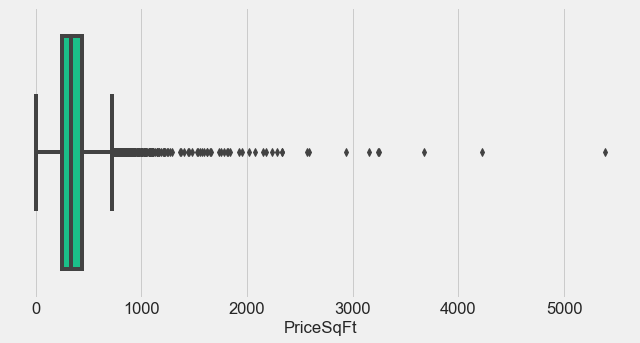

In [284]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=eda12['PriceSqFt']);

#### Results
From the plot we can see the heavy presence of outliers on the right-hand side of the distribution.

# Removing Outliers
Checking if we can improve the coefficient of determination or the results our assumption tests by getting rid of the outliers in the data using the IQR fences method.

## Calculating Quartiles & IQR

In [285]:
# calculating Q1, Q3 and IQR
Q1 = eda12['PriceSqFt'].quantile(0.25)
Q3 = eda12['PriceSqFt'].quantile(0.75)
IQR = Q3 - Q1
IQR

189.41929024605056

## Statistics of the Outliers

In [286]:
# checking the Stats of the outliers
eda12[((eda12['SalePrice'] < (Q1 - 1.5 * IQR))\
     | (eda12['SalePrice'] > (Q3 + 1.5 * IQR)))]['SalePrice'].describe()

count    1.530900e+04
mean     6.690826e+05
std      2.818903e+05
min      1.000000e+03
25%      4.499500e+05
50%      6.200000e+05
75%      8.300000e+05
max      1.526000e+06
Name: SalePrice, dtype: float64

### Results

All of the outliers are on the right. The minimum value of the outliers is well above the median and mean of the model data set, which is in line with the boxplot above.

## Creating No Outliers Test Data Frame
Removing outliers, checking shape, and statistics.

In [287]:
no_outliers12 = eda12[~((eda12['PriceSqFt'] < (Q1 - 1.5 * IQR))\
                   | (eda12['PriceSqFt'] > (Q3 + 1.5 * IQR)))]

In [288]:
no_outliers12.head(2)

,SalePrice,SqFtTotLiving,Bins,StrBins,PriceSqFt
5,560000.0,1930,"(1084.222, 2052.444]","(1084.222, 2052.444]",290.155440
6,435000.0,1975,"(1084.222, 2052.444]","(1084.222, 2052.444]",220.253165


### Visualizing The Data
Looks much better.

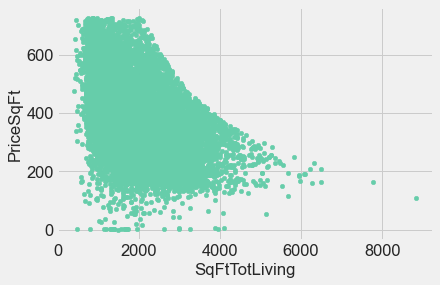

In [289]:
no_outliers12.plot.scatter(x='SqFtTotLiving',\
                           y='PriceSqFt', color='mediumaquamarine' );

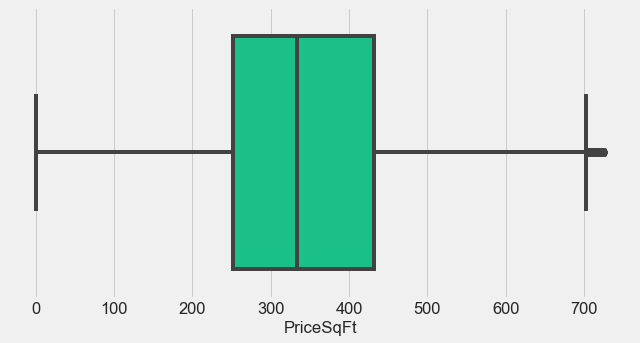

In [290]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=no_outliers12['PriceSqFt']);

# Write Up Model 12

# Model 12: Testing the Removal of `PriceSqFt` Outliers
Square-root transforming `SqFtTotLiving`, creating & fitting the model, and checking results.

#### Data Frame

In [291]:
model12_df = no_outliers12[['SalePrice', 'SqFtTotLiving']].copy()
model12_df['SqFtTotLiving_sqrt'] = np.sqrt(model12_df['SqFtTotLiving'])
model12_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [292]:
model12 = ols(formula="SalePrice ~ SqFtTotLiving_sqrt", data=model12_df)
model12_results = model12.fit()

#### Model Result: R-Squared = .343

In [293]:
model12_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     7791.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:42   Log-Likelihood:            -2.0503e+05
No. Observations:               14913   AIC:                         4.101e+05
Df Residuals:                   14911   BIC:                         4.101e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.872e+05   9813.632    -19.079      0.000   -2.06e+05   -1.68e+05
SqFtTotLiving_sqrt  1.942e+04    220.016     88.267      0.000     1.9e+04    1.99e+04
==============================================================================
Omnibus:                      387.662   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              418.241
Skew:                           0.402   Prob(JB):                     1.51e-91
Kurtosis:                       3.167   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Intrepreting the Results
The coefficient for `SqFtTotLiving` indicates that every 1 foot increase in total living  space will increase `SalePrice` by \$19,000. 

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [294]:
fn.rainbow(model12_results)

Rainbow statistic: 1.0007383725716756
Rainbow p-value: 0.4872906164952993


#### Result: Pass

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

#### Error Plot

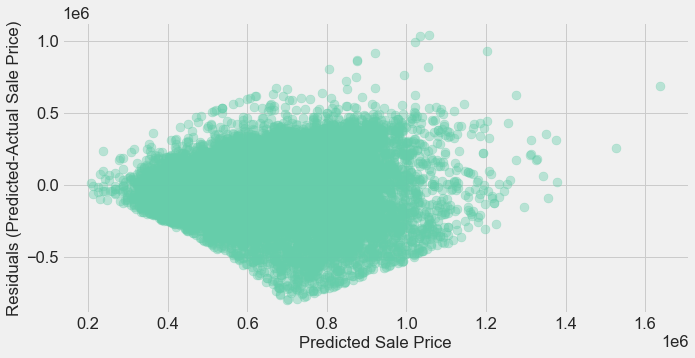

In [295]:
vz.error_plot(model12_df, 'SalePrice', model12_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with a peak of under-predictions near the middle of the predicted price range.

#### Breusch-Pagan Test

In [296]:
fn.bp_test(model12_df, 'SalePrice', model12_results)

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


#### Result: Fail
Confirms the result from the error plot.

### VIF Test:

Since the model only has one feature, it is independent by definition.

#### Results: N/A

#### Bottom Line on the Results
R-squared has been vastly improved from .287 to .343. The p-values and CIs for the coefficient and intercept are valid. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. The residuals have improved somewhat by losing the under-predictions on the low end. Square-root scaling the `SqFtTotLiving` feature has improved the model.


# Data Cleaning

# Removing Outliers
After running the test above, dropping the price per square foot outliers.

## Calculating Quartiles & IQR

In [297]:
# creating price per square foot feature
no_outliers['PriceSqFt'] = no_outliers['SalePrice']/no_outliers['SqFtTotLiving']

In [298]:
# calculating Q1, Q3 and IQR
Q1 = no_outliers['PriceSqFt'].quantile(0.25)
Q3 = no_outliers['PriceSqFt'].quantile(0.75)
IQR = Q3 - Q1
IQR

189.41929024605056

## Creating Cleaned Data Frame

In [299]:
clean_df = no_outliers[~((no_outliers['PriceSqFt'] < (Q1 - 1.5 * IQR))\
                   | (no_outliers['PriceSqFt'] > (Q3 + 1.5 * IQR)))].copy()

In [300]:
clean_df.head(2)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,PropType,DistrictName,SqFtLot,WaterSystem,...,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear,ZipClean,PriceSqFt
5,560000.0,2130430120,3027422,2019-12-20,11,6,R,DUVALL,10523,2,...,1989,0,0,0,0,3,0,2019,98019,290.155440
6,435000.0,9406520630,3002257,2019-07-22,11,6,R,MAPLE VALLEY,7392,2,...,1994,0,0,0,0,3,2500,2019,98038,220.253165


# Write Model 13 Results

# Model 13: Cleaned DF & `HeatSystem`

#### Data Frame

In [301]:
initial13_df = clean_df[['SalePrice', 'SqFtTotLiving', 'HeatSystem']].copy()

#### Transforming `SqFtTotLiving`
Square-rooting the feature and dropping the original column.

In [302]:
initial13_df['SqFtTotLiving_sqrt'] = np.sqrt(initial13_df['SqFtTotLiving'])

In [303]:
initial13_df.drop('SqFtTotLiving', axis=1, inplace=True)

#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame

In [304]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [305]:
# restting index
initial13_df.reset_index(inplace=True, drop=True)

In [306]:
# creating HeatNames column 
initial13_df['HeatNames'] = initial13_df.HeatSystem.map(heatnames)

In [307]:
# dropping HeatSystem column
fn.dropper(initial13_df, 'HeatSystem', True)

#### Checking for `NaN` values and replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [308]:
# checking for NaNs
initial13_df['HeatNames'].isna().sum()

9

In [309]:
# filling NaNs with strings
initial13_df.fillna('NA', inplace=True)

In [310]:
# checking work
initial13_df.isna().sum()

SalePrice             0
SqFtTotLiving_sqrt    0
HeatNames             0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `initial13_df[['HeatNames']]` , and transforming the data. Creating a new `heat2_ohe` data frame, dropping the `'HeatNames'` column to form an `initial_dropped` data frame, and concatenating it with `heat_ohe` to form a new `model13_df` data frame.

In [311]:
transformed = fn.one_hot(initial13_df, 'HeatNames')

In [312]:
# creating heat_ohe data frame and checking the first few columns
heat2_ohe = pd.DataFrame(transformed[1].todense(),\
                       columns = transformed[0].get_feature_names())
heat2_ohe.head(1)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
# dropping the 'HeatNames' column from heat_df
initial_dropped = initial13_df.drop('HeatNames', axis=1)

#### Creating `model13_df` Data Frame

In [314]:
# creating the model dataframe and checking first few rows
model13_df = pd.concat([initial_dropped, heat2_ohe], axis=1)
model13_df.head(2)

,SalePrice,SqFtTotLiving_sqrt,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,43.931765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,435000.0,44.440972,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cleaning `HeatNames` Column Strings
Stripping whitespaces and converting hyphens to underscores.

In [315]:
# stripping white space
model13_df.columns = model13_df.columns.str.replace(' ', '_')

In [316]:
# converting hyphens
model13_df.columns = model13_df.columns.str.replace('-', '_')

In [317]:
# checking work
print(model13_df.shape)
model13_df.head(1)

(14913, 10)


,SalePrice,SqFtTotLiving_sqrt,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,43.931765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `model13_df` Correlation List, Matrix, and Heatmap

In [318]:
np.abs(model13_df.corr().SalePrice).sort_values(ascending=False)

SalePrice             1.000000
SqFtTotLiving_sqrt    0.585822
x0_Floor_Wall         0.102220
x0_Forced_Air         0.082860
x0_Heat_Pump          0.078564
x0_Hot_Water          0.058439
x0_Radiant            0.041983
x0_NA                 0.022176
x0_Gravity            0.015090
x0_Other              0.001798
Name: SalePrice, dtype: float64

In [319]:
corr = model13_df.corr()

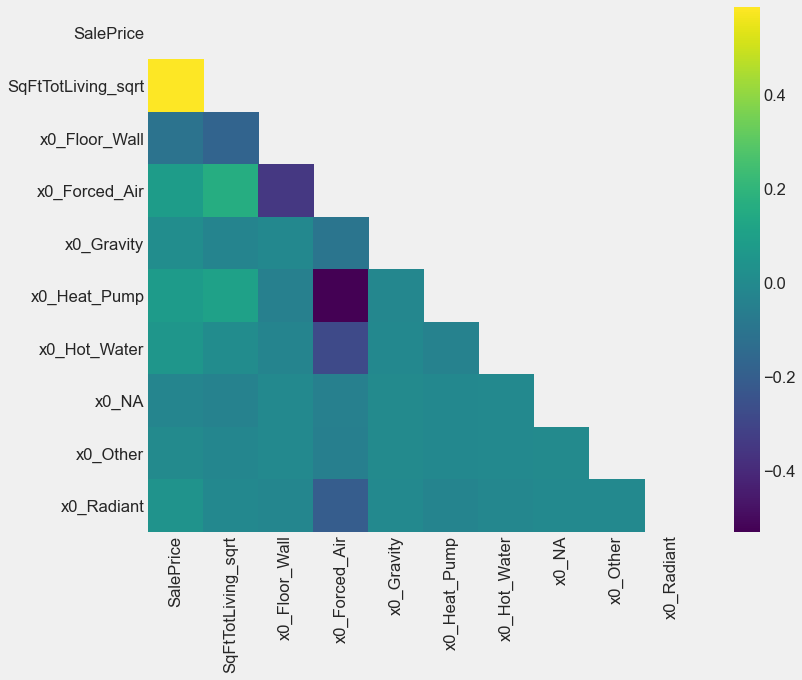

In [320]:
vz.heat_map(corr)

#### Formula

In [321]:
formula = fn.create_formula('SalePrice', model13_df)

#### Model

In [322]:
model13 = ols(formula, data=model13_df)

In [323]:
model13_results = model13.fit();

#### Model Result: R-Squared = .352

In [324]:
model13_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     900.5
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:44   Log-Likelihood:            -2.0493e+05
No. Observations:               14913   AIC:                         4.099e+05
Df Residuals:                   14903   BIC:                         4.100e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.233e+05   1.09e+04    -20.496      0.000   -2.45e+05   -2.02e+05
SqFtTotLiving_sqrt    1.9e+04    229.634     82.755      0.000    1.86e+04    1.95e+04
x0_Floor_Wall       4.951e+04   1.26e+04      3.930      0.000    2.48e+04    7.42e+04
x0_Forced_Air       5.287e+04   7329.600      7.214      0.000    3.85e+04    6.72e+04
x0_Gravity          2.302e+05   3.86e+04      5.962      0.000    1.55e+05    3.06e+05
x0_Heat_Pump         7.49e+04   1.01e+04      7.386      0.000     5.5e+04    9.48e+04
x0_Hot_Water        1.625e+05    1.5e+04     10.824      0.000    1.33e+05    1.92e+05
x0_NA               3.481e+04   7.53e+04      0.462      0.644   -1.13e+05    1.82e+05
x0_Other            1.868e+05   7.14e+04      2.616      0.009    4.68e+04    3.27e+05
x0_Radiant          1.797e+05   1.93e+04      9.311      0.000    1.42e+05    2.18e+05
==============================================================================
Omnibus:                      385.500   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              416.252
Skew:                           0.398   Prob(JB):                     4.09e-91
Kurtosis:                       3.191   Cond. No.                     1.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpreting the Results
The `ElecBB` heating system category was dropped in encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices relative to homes with `ElecBB` heating when holding `SqFtTotLiving_sqrt` constant. Conversely, when holding the other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that for every 1 foot increase in living space will result in a \$19,000 increase in `SalePrice`. 

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [325]:
fn.rainbow(model13_results)

Rainbow statistic: 0.9999925252019304
Rainbow p-value: 0.5001309770660752


#### Result: Pass

The test p-value is greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

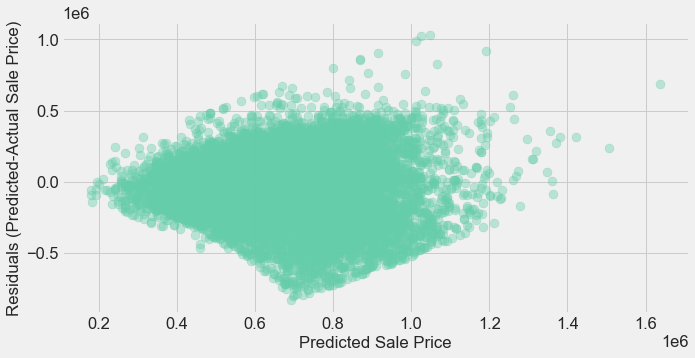

In [326]:
vz.error_plot(model13_df, 'SalePrice', model13_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with a peak of under-predictions near the middle of the predicted price range.

### Bruesch-Pagan Test

In [327]:
fn.bp_test(model13_df, 'SalePrice', model13_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [328]:
fn.vif(model13_df)

,VIF,feature
0,12.126626,SqFtTotLiving_sqrt
1,1.232923,x0_Floor_Wall
2,10.617249,x0_Forced_Air
3,1.021890,x0_Gravity
4,1.896471,x0_Heat_Pump
5,1.229569,x0_Hot_Water
6,1.003665,x0_NA
7,1.005854,x0_Other
8,1.119005,x0_Radiant


#### Result: Fail
The VIF values for the SqFtTotLiving_log and x0_Forced_Air coefficients are above 5, indicating that there is multicollinearity in the features.

### Bottom Line on the  Results
R-squared has improved from .343 to .352. All p-values and CIs are valid except for the `NA` category. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. The VIF numbers for SqFtTotLiving_log and x0_Forced_Air show multicollinearity. Adding the `HeatSystem` feature has improved the model slightly.

# Model 14 Testing The Addition of Multiple Features
Adding some more continuous features to to model. Choosing features that are more highly correlated to `SalePrice`.

#### Data Frame

In [329]:
initial14_df = clean_df[['SalePrice', 'SqFtTotLiving', 'HeatSystem',\
                         'SqFtOpenPorch', 'SqFtEnclosedPorch',\
                         'SqFtDeck', 'SqFtFinBasement', 'Bedrooms']].copy()

#### Square Root Transforming `SqFtTotLiving`

In [330]:
initial14_df['SqFtTotLiving_sqrt'] = np.sqrt(initial14_df['SqFtTotLiving'])

In [331]:
initial14_df.drop('SqFtTotLiving', axis=1, inplace=True)

In [332]:
initial14_df.shape

(14913, 8)

In [333]:
initial14_df.head(1)

,SalePrice,HeatSystem,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt
5,560000.0,5,180,0,0,0,3,43.931765


#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame
Doing the familiar prep process on the `HeatSystem` feature.

In [334]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [335]:
initial14_df.reset_index(inplace=True, drop=True)

In [336]:
initial14_df['HeatNames'] = initial14_df.HeatSystem.map(heatnames)

In [337]:
fn.dropper(initial14_df, 'HeatSystem', True)

#### Replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [338]:
# filling NaNs with strings
initial14_df.fillna('NA', inplace=True)

In [339]:
# checking work
initial14_df.isna().sum()

SalePrice             0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
SqFtFinBasement       0
Bedrooms              0
SqFtTotLiving_sqrt    0
HeatNames             0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `initial14_df[['HeatNames']]` , and transforming the data. Creating a new `heat2_ohe` data frame, dropping the `'HeatNames'` column to form an `initial_dropped` data frame, and concatenating it with `heat_ohe` to form a new `model14_df` data frame.

In [340]:
transformed = fn.one_hot(initial14_df, 'HeatNames')

In [341]:
# creating heat_ohe data frame and checking the first few columns
heat3_ohe = pd.DataFrame(transformed[1].todense(),\
                       columns = transformed[0].get_feature_names())
heat3_ohe.head(1)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [342]:
# dropping the 'HeatNames' column from heat_df
initial14_dropped = initial14_df.drop('HeatNames', axis=1)

#### Creating `model14_df` Data Frame

In [343]:
# creating the model dataframe and checking first few rows
model14_df = pd.concat([initial14_dropped, heat3_ohe], axis=1)
model14_df.head(2)

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,180,0,0,0,3,43.931765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,435000.0,45,0,0,0,3,44.440972,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cleaning `HeatNames` Column Strings
Stripping whitespaces and converting hyphens to underscores.

In [344]:
model14_df.columns = model14_df.columns.str.replace(' ', '_')

In [345]:
model14_df.columns = model14_df.columns.str.replace('-', '_')

In [346]:
# checking work
print(model14_df.shape)
model14_df.head(1)

(14913, 15)


,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant
0,560000.0,180,0,0,0,3,43.931765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `model14_df` Correlation List, Matrix, and Heatmap

In [347]:
np.abs(model14_df.corr().SalePrice).sort_values(ascending=False)

SalePrice             1.000000
SqFtTotLiving_sqrt    0.585822
Bedrooms              0.292586
SqFtFinBasement       0.250674
SqFtDeck              0.201045
SqFtOpenPorch         0.180874
x0_Floor_Wall         0.102220
x0_Forced_Air         0.082860
x0_Heat_Pump          0.078564
x0_Hot_Water          0.058439
x0_Radiant            0.041983
x0_NA                 0.022176
x0_Gravity            0.015090
SqFtEnclosedPorch     0.002246
x0_Other              0.001798
Name: SalePrice, dtype: float64

In [348]:
corr = model14_df.corr()

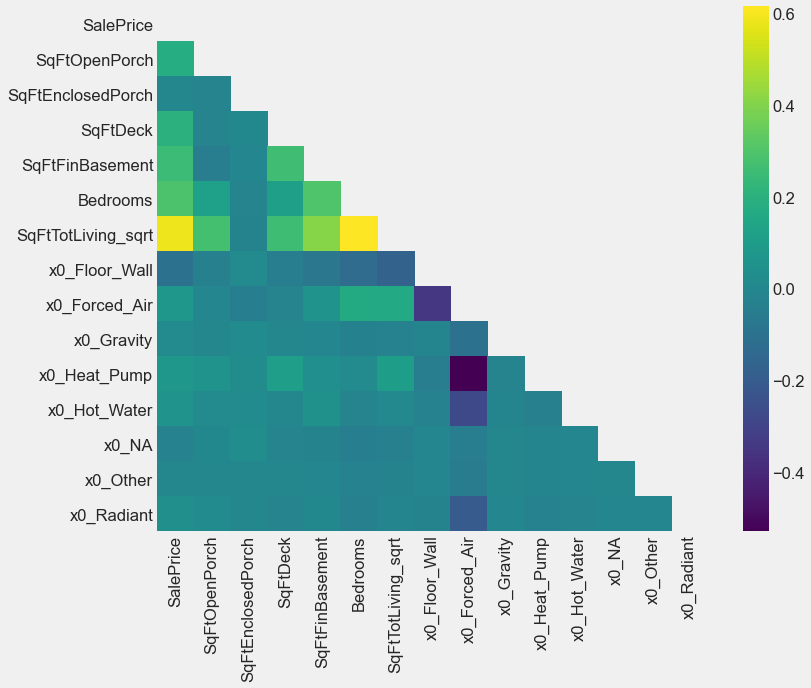

In [349]:
vz.heat_map(corr)

#### Formula

In [350]:
formula = fn.create_formula('SalePrice', model14_df)

#### Model

In [351]:
model14 = ols(formula, data=model14_df)

In [352]:
model14_results = model14.fit();

#### Model Result: R-Squared = .362

In [353]:
model14_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     603.1
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:47   Log-Likelihood:            -2.0482e+05
No. Observations:               14913   AIC:                         4.097e+05
Df Residuals:                   14898   BIC:                         4.098e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.869e+05   1.16e+04    -16.182      0.000    -2.1e+05   -1.64e+05
SqFtOpenPorch         61.7301     19.447      3.174      0.002      23.612      99.848
SqFtEnclosedPorch     97.5956     53.937      1.809      0.070      -8.128     203.319
SqFtDeck              67.0221      9.570      7.003      0.000      48.263      85.781
SqFtFinBasement        7.5058      4.811      1.560      0.119      -1.924      16.935
Bedrooms            -3.23e+04   2706.695    -11.935      0.000   -3.76e+04    -2.7e+04
SqFtTotLiving_sqrt  2.026e+04    315.108     64.283      0.000    1.96e+04    2.09e+04
x0_Floor_Wall         4.8e+04   1.25e+04      3.836      0.000    2.35e+04    7.25e+04
x0_Forced_Air       5.695e+04   7285.328      7.817      0.000    4.27e+04    7.12e+04
x0_Gravity           2.21e+05   3.83e+04      5.762      0.000    1.46e+05    2.96e+05
x0_Heat_Pump         6.76e+04   1.01e+04      6.703      0.000    4.78e+04    8.74e+04
x0_Hot_Water        1.596e+05   1.49e+04     10.693      0.000     1.3e+05    1.89e+05
x0_NA               8165.3173   7.48e+04      0.109      0.913   -1.38e+05    1.55e+05
x0_Other            1.713e+05   7.09e+04      2.415      0.016    3.22e+04     3.1e+05
x0_Radiant          1.743e+05   1.92e+04      9.090      0.000    1.37e+05    2.12e+05
==============================================================================
Omnibus:                      398.635   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.490
Skew:                           0.397   Prob(JB):                     4.48e-95
Kurtosis:                       3.262   Cond. No.                     2.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [354]:
model14_results.params

Intercept            -186913.677763
SqFtOpenPorch             61.730102
SqFtEnclosedPorch         97.595639
SqFtDeck                  67.022100
SqFtFinBasement            7.505812
Bedrooms              -32303.328933
SqFtTotLiving_sqrt     20256.221814
x0_Floor_Wall          47995.519825
x0_Forced_Air          56948.824207
x0_Gravity            220965.058542
x0_Heat_Pump           67597.454480
x0_Hot_Water          159605.822691
x0_NA                   8165.317331
x0_Other              171259.542394
x0_Radiant            174334.902332
dtype: float64

#### Interpreting the Results
The `ElecBB` heating system category was dropped in encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices (determined by the various heat type coefficients) relative to homes with `ElecBB` heating when holding all other features constant. Also, when holding all other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that every one foot increase in living space will result in a \$20,000 increase in `SalePrice`. Further, a one square-foot increase in each of the other continuous SqFt features will slightly increase (by the various coefficients) `SalePrice` when holding all other features constant. Oddly, the model indicates that `SalePrice` will decrease by \$32,000 for each bedroom added when holding the other features constant.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [355]:
fn.rainbow(model14_results)

Rainbow statistic: 0.9978754351657456
Rainbow p-value: 0.53656586898371


#### Result: Pass

The test p-value is greater than .05, so the model is linearly determined by the predictors.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value of is close to 0.00, so the model violates the normality assumption.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

### Error Plot

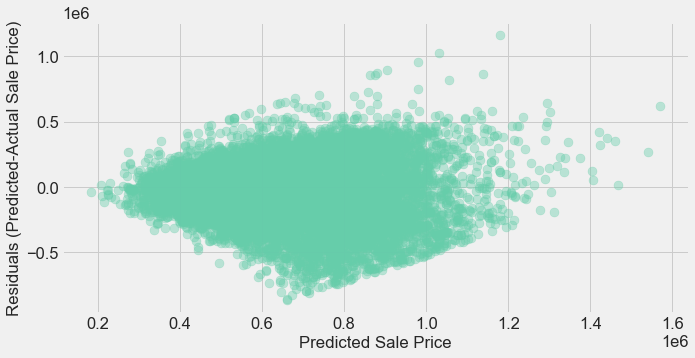

In [356]:
vz.error_plot(model14_df, 'SalePrice', model14_results)

#### Result: Fail
Hetroscadasicity is present in the graph, with a peak of under-predictions near the middle of the predicted price range.

### Bruesch-Pagan Test

In [357]:
fn.bp_test(model14_df, 'SalePrice', model14_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result:Fail
The p-value of 0 indicates that the variance of the target is not homogeneous across values of the predictor, verifying what was found in the graph.

### Independence Check:  Variance Inflation Factor

In [358]:
fn.vif(model14_df)

,VIF,feature
0,1.442985,SqFtOpenPorch
1,1.027733,SqFtEnclosedPorch
2,1.610946,SqFtDeck
3,1.753920,SqFtFinBasement
4,26.075354,Bedrooms
5,38.779529,SqFtTotLiving_sqrt
6,1.255408,x0_Floor_Wall
7,10.966052,x0_Forced_Air
8,1.022774,x0_Gravity
9,1.910161,x0_Heat_Pump


#### Result: Fail
The VIF values for multiple coefficients are above 5, indicating that there is strong multicollinearity in the features.

### Bottom Line on the  Results
R-squared has improved slightly from .352 to .362. All p-values and CIs are valid except for the `NA` and `SqFtFinBasement` categories. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals. The VIF numbers for multiple features show strong multicollinearity, making the violation of this assumptiom worse. Adding the new features has worsened some of our assumption checks without adding much to our coefficient of determination. 

## Investigating the Residuals
Doing some EDA, since adding features hasn't added much value. Taking a closer look at the peak of residuals in the erroe plot.

#### Adding `y_hat` & `residuals` Column to the model14 Data Frame

In [359]:
model14_df['y_hat'] = model14_results.predict()

In [360]:
model14_df['residual'] = model14_results.predict() - model14_df['SalePrice']

#### Filtering the Data to Focus in on the the bottom point of the graph.

In [361]:
# filtering down to the interval .6< y_hat <.8
filter1 = model14_df[(model14_df.y_hat>.6*(10**6))|(model14_df.y_hat<.8*(10**6))].copy()

In [362]:
# filtering down to the tip of the peak
filter2 = filter1[(filter1.y_hat-filter1.SalePrice) < -.25*(10**6)]

#### Checking Work & Plotting Results

In [363]:
filter2.head(1)

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant,y_hat,residual
2,1255000.0,0,330,790,920,4,51.768716,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,881519.80036,-373480.19964


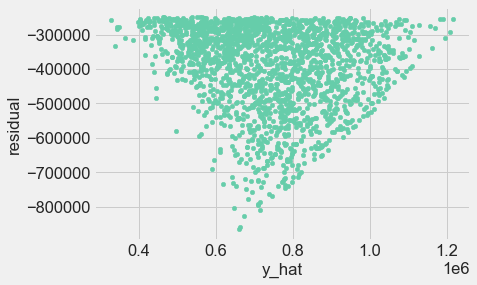

In [364]:
filter2.plot.scatter(x='y_hat',y='residual', color='mediumaquamarine');

#### Comparing the Stats of Points in the Region vs All Points in `model14_df`

In [365]:
filter2.describe()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant,y_hat,residual
count,1.933000e+03,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.0,1933.000000,1933.000000,1.933000e+03,1933.000000
mean,1.132196e+06,70.090016,5.855147,158.962235,380.876875,3.633213,47.761401,0.009829,0.845835,0.001035,0.071909,0.024315,0.0,0.001552,0.009312,7.410984e+05,-391097.440318
std,2.124708e+05,107.374319,30.416156,212.146186,468.175415,0.828750,7.915025,0.098680,0.361200,0.032158,0.258404,0.154064,0.0,0.039375,0.096073,1.594697e+05,119960.547039
min,5.850000e+05,0.000000,0.000000,0.000000,0.000000,1.000000,29.325757,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.272297e+05,-865458.150367
25%,9.650000e+05,0.000000,0.000000,0.000000,0.000000,3.000000,41.713307,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6.244329e+05,-463904.583899
50%,1.150000e+06,40.000000,0.000000,70.000000,90.000000,4.000000,47.539457,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,7.348107e+05,-358272.455371
75%,1.300000e+06,100.000000,0.000000,270.000000,740.000000,4.000000,53.291650,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8.551719e+05,-292774.987465
max,1.526000e+06,1090.000000,470.000000,1500.000000,2500.000000,9.000000,71.344236,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.214921e+06,-250076.709693


In [366]:
model14_df.describe()

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,SqFtFinBasement,Bedrooms,SqFtTotLiving_sqrt,x0_Floor_Wall,x0_Forced_Air,x0_Gravity,x0_Heat_Pump,x0_Hot_Water,x0_NA,x0_Other,x0_Radiant,y_hat,residual
count,1.491300e+04,14913.000000,14913.000000,14913.000000,14913.000000,14913.000000,14913.000000,14913.000000,14913.00000,14913.000000,14913.000000,14913.000000,14913.000000,14913.000000,14913.000000,1.491300e+04,1.491300e+04
mean,6.633940e+05,56.353450,5.483068,133.755582,296.721183,3.374841,43.801371,0.030242,0.79709,0.002347,0.066452,0.019245,0.000604,0.000671,0.010461,6.633940e+05,4.724996e-10
std,2.792879e+05,99.972623,33.954062,202.706154,430.823103,0.865431,8.424913,0.171258,0.40218,0.048390,0.249079,0.137389,0.024560,0.025887,0.101744,1.679792e+05,2.231249e+05
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,20.248457,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.816508e+05,-8.654582e+05
25%,4.450000e+05,0.000000,0.000000,0.000000,0.000000,3.000000,37.682887,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.450774e+05,-1.443554e+05
50%,6.150000e+05,0.000000,0.000000,0.000000,0.000000,3.000000,43.358967,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.550179e+05,1.827214e+04
75%,8.250000e+05,80.000000,0.000000,210.000000,590.000000,4.000000,49.295030,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.684202e+05,1.656557e+05
max,1.526000e+06,1860.000000,670.000000,2100.000000,2500.000000,10.000000,93.968080,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.570345e+06,1.164053e+06


#### Checking the Difference in the Means

In [367]:
mean_diff = filter2.mean() - model14_df.mean()
mean_diff

SalePrice             468801.845154
SqFtOpenPorch             13.736566
SqFtEnclosedPorch          0.372079
SqFtDeck                  25.206652
SqFtFinBasement           84.155692
Bedrooms                   0.258372
SqFtTotLiving_sqrt         3.960030
x0_Floor_Wall             -0.020413
x0_Forced_Air              0.048746
x0_Gravity                -0.001312
x0_Heat_Pump               0.005457
x0_Hot_Water               0.005070
x0_NA                     -0.000604
x0_Other                   0.000881
x0_Radiant                -0.001149
y_hat                  77704.404837
residual             -391097.440318
dtype: float64

In [368]:
# converting SqFtTotLiving_sqrt back to SqFt
(mean_diff[6])**2

15.681841540597732

#### Dropping The Filtered Data & Plotting

In [369]:
point_drop = model14_df.drop(filter2.index)

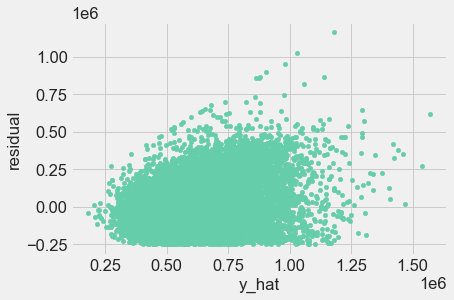

In [370]:
point_drop.plot.scatter(x='y_hat',y='residual', color='mediumaquamarine');

#### Bottom Line
Homes in the tip of the residuals are just marginally bigger overall, but have bigger open porches, decks, and finished basments. They are also much more expensive; The mean price difference between the groups is \$468801. The analysis necessary to fully parse the features of the homes in this group is beyond the scope of this project, but could be a meaningful next step moving forward. 

# Next Steps: Further Investigation of Outliers in the Residuals

# Model 15: Testing The Filtered Data
Even without digging deeper into the residuals, testingthe filtered data could be valuable.

#### Data Frame

In [371]:
# checking columns
point_drop.columns

Index(['SalePrice', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'SqFtFinBasement', 'Bedrooms', 'SqFtTotLiving_sqrt', 'x0_Floor_Wall',
       'x0_Forced_Air', 'x0_Gravity', 'x0_Heat_Pump', 'x0_Hot_Water', 'x0_NA',
       'x0_Other', 'x0_Radiant', 'y_hat', 'residual'],
      dtype='object')

In [372]:
# dropping extraneous columns
model15_df = point_drop.drop(['Bedrooms','y_hat', 'residual'], axis=1)

#### Model

In [373]:
formula = fn.create_formula('SalePrice', model15_df)

In [374]:
model15 = ols(formula=formula, data=model15_df)
model15_results = model15.fit()

#### Model Result: R-Squared = .378

In [375]:
model15_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     605.7
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:50   Log-Likelihood:            -1.7458e+05
No. Observations:               12980   AIC:                         3.492e+05
Df Residuals:                   12966   BIC:                         3.493e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -8.212e+04   9162.232     -8.963      0.000      -1e+05   -6.42e+04
SqFtOpenPorch         68.5054     15.865      4.318      0.000      37.408      99.603
SqFtEnclosedPorch     65.9264     42.871      1.538      0.124     -18.107     149.960
SqFtDeck              72.6304      7.763      9.356      0.000      57.415      87.846
SqFtFinBasement        2.1774      3.961      0.550      0.583      -5.586       9.941
SqFtTotLiving_sqrt   1.42e+04    217.236     65.354      0.000    1.38e+04    1.46e+04
x0_Floor_Wall       5.228e+04   9650.525      5.417      0.000    3.34e+04    7.12e+04
x0_Forced_Air       4.619e+04   5690.274      8.117      0.000     3.5e+04    5.73e+04
x0_Gravity           2.45e+05   2.97e+04      8.245      0.000    1.87e+05    3.03e+05
x0_Heat_Pump        7.123e+04   8030.988      8.869      0.000    5.55e+04     8.7e+04
x0_Hot_Water        1.423e+05   1.21e+04     11.726      0.000    1.19e+05    1.66e+05
x0_NA               3.451e+04   5.63e+04      0.613      0.540   -7.58e+04    1.45e+05
x0_Other            7.101e+04   6.37e+04      1.115      0.265   -5.39e+04    1.96e+05
x0_Radiant          1.751e+05   1.53e+04     11.459      0.000    1.45e+05    2.05e+05
==============================================================================
Omnibus:                       94.985   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.733
Skew:                          -0.048   Prob(JB):                     3.23e-15
Kurtosis:                       2.662   Cond. No.                     2.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [376]:
model15_results.params

Intercept             -82119.880718
SqFtOpenPorch             68.505361
SqFtEnclosedPorch         65.926408
SqFtDeck                  72.630442
SqFtFinBasement            2.177384
SqFtTotLiving_sqrt     14197.208388
x0_Floor_Wall          52278.725167
x0_Forced_Air          46190.655892
x0_Gravity            245006.768903
x0_Heat_Pump           71227.971204
x0_Hot_Water          142305.307542
x0_NA                  34507.777000
x0_Other               71010.272495
x0_Radiant            175051.197464
dtype: float64

#### Interpreting the Results
The `ElecBB` heating system category was dropped in encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices (determined by the various heat type coefficients) relative to homes with `ElecBB` heating when holding all other features constant. Also, when holding all other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that every one foot increase in living space will result in a \$14,000 increase in `SalePrice`. Lastly, a one square-foot increase in each of the other continuous SqFt features will slightly increase (by the various coefficients) `SalePrice` when holding all other features constant. 

### Linearity Check: Rainbow Test

In [377]:
fn.rainbow(model15_results)

Rainbow statistic: 0.993863407055936
Rainbow p-value: 0.5978595725538962


#### Result: Pass
Since the p-value is above .05.

### Homoscadasticity Check

#### Error Plot

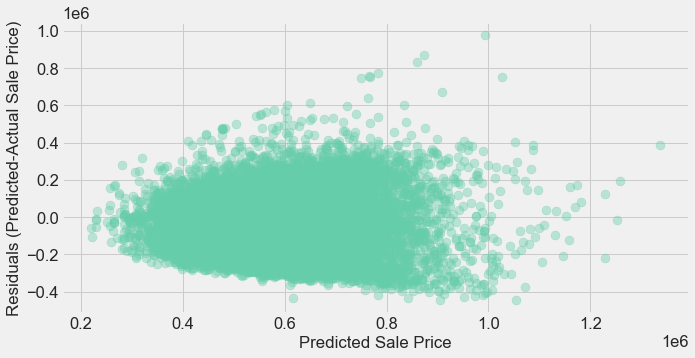

In [378]:
vz.error_plot(model15_df, 'SalePrice', model15_results)

#### Breusch-Pagan Test

In [379]:
fn.bp_test(model15_df, 'SalePrice', model15_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result: Fail

### Independence Check:  Variance Inflation Factor

In [380]:
fn.vif(model15_df)

,VIF,feature
0,1.415030,SqFtOpenPorch
1,1.026670,SqFtEnclosedPorch
2,1.581089,SqFtDeck
3,1.728970,SqFtFinBasement
4,14.498649,SqFtTotLiving_sqrt
5,1.268777,x0_Floor_Wall
6,10.320716,x0_Forced_Air
7,1.023569,x0_Gravity
8,1.866232,x0_Heat_Pump
9,1.210219,x0_Hot_Water


#### Result: Fail

### Bottom Line on the  Results
R-squared has improved slightly from .362 to .378. All p-values and CIs are valid except for the `NA`, `Other`, `SqFtFinBasement`, and `SqFtEnclosedPorch` categories. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals, but looks better than the non-filtered data. The VIF numbers for two of the features show multicollinearity.

# Model 16 A & B: Experimenting With Forward Selected Features on Filtered Data
Using a forward selection process to return a model with the best performing features.

## Model16 A

#### Data Frame

In [381]:
model16raw_df = model15_df.copy()

#### Model

In [382]:
model16raw_results = fn.forward_selected(model16raw_df, 'SalePrice')

#### Model Result: R-Squared = .378

In [383]:
model16raw_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     715.9
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:52   Log-Likelihood:            -1.7458e+05
No. Observations:               12980   AIC:                         3.492e+05
Df Residuals:                   12968   BIC:                         3.493e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -8.317e+04   8769.604     -9.483      0.000      -1e+05    -6.6e+04
SqFtTotLiving_sqrt  1.424e+04    200.015     71.203      0.000    1.38e+04    1.46e+04
SqFtDeck              73.3275      7.653      9.581      0.000      58.326      88.329
x0_Radiant          1.749e+05   1.53e+04     11.455      0.000    1.45e+05    2.05e+05
x0_Hot_Water        1.424e+05   1.21e+04     11.756      0.000    1.19e+05    1.66e+05
x0_Gravity          2.449e+05   2.97e+04      8.242      0.000    1.87e+05    3.03e+05
x0_Heat_Pump         7.09e+04   8016.919      8.844      0.000    5.52e+04    8.66e+04
x0_Forced_Air       4.592e+04   5670.967      8.098      0.000    3.48e+04     5.7e+04
x0_Floor_Wall       5.198e+04   9637.157      5.393      0.000    3.31e+04    7.09e+04
SqFtOpenPorch         67.0720     15.609      4.297      0.000      36.476      97.668
SqFtEnclosedPorch     66.6919     42.847      1.557      0.120     -17.294     150.678
x0_Other            7.077e+04   6.37e+04      1.111      0.267   -5.41e+04    1.96e+05
==============================================================================
Omnibus:                       95.982   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.260
Skew:                          -0.048   Prob(JB):                     2.48e-15
Kurtosis:                       2.661   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [384]:
model16raw_results.params

Intercept             -83165.771549
SqFtTotLiving_sqrt     14241.551610
SqFtDeck                  73.327480
x0_Radiant            174882.334233
x0_Hot_Water          142362.372656
x0_Gravity            244858.342018
x0_Heat_Pump           70898.602497
x0_Forced_Air          45922.767375
x0_Floor_Wall          51977.787496
SqFtOpenPorch             67.072005
SqFtEnclosedPorch         66.691860
x0_Other               70774.990287
dtype: float64

#### Interpreting the Results
The results similar to the results from model15. The `SqFtFinBasement` and `NA` features were dropped in the forward selection process and not included in the model. The `ElecBB` heating system category was dropped during encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices (determined by the various heat type coefficients) relative to homes with `ElecBB` heating when holding all other features constant. Also, when holding all other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that every one foot increase in living space will result in a \$14,000 increase in `SalePrice`. Further, a one square-foot increase in each of the other continuous SqFt features will slightly increase (by the various coefficients) `SalePrice` when holding all other features constant.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [385]:
fn.rainbow(model16raw_results)

Rainbow statistic: 0.9942017850326135
Rainbow p-value: 0.5925555106093634


#### Results: Pass
Since the p-value is above .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the features.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value close to 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

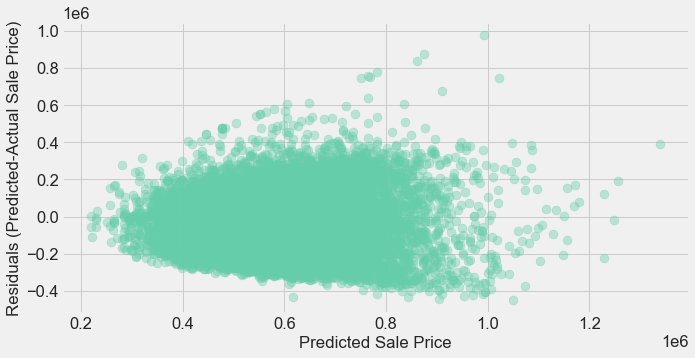

In [386]:
vz.error_plot(model16raw_df, 'SalePrice', model16raw_results)

In [387]:
fn.bp_test(model16raw_df, 'SalePrice', model16raw_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result: Fail.
Since our p-value is 0, we reject the null hypothesis and conclude that the variance of the target is not homogeneous across all values of the predictors. This agrees with the error plot above.

### Independence Check:  Variance Inflation Factor

In [388]:
fn.vif(model16raw_df)

,VIF,feature
0,1.415030,SqFtOpenPorch
1,1.026670,SqFtEnclosedPorch
2,1.581089,SqFtDeck
3,1.728970,SqFtFinBasement
4,14.498649,SqFtTotLiving_sqrt
5,1.268777,x0_Floor_Wall
6,10.320716,x0_Forced_Air
7,1.023569,x0_Gravity
8,1.866232,x0_Heat_Pump
9,1.210219,x0_Hot_Water


#### Result: Fail
Since two the VIF values are greater than five, we conclude the the model has multicollinearities.

## Model16 B
Dropping `Forced Air` by hand, to see if we can improve the VIF numbers.

#### Data Frame

In [389]:
model16trim_df = model16raw_df.drop(['x0_Forced_Air'] , axis=1).copy()

#### Model

In [390]:
model16trim_results = fn.forward_selected(model16trim_df, 'SalePrice')

#### Model Results: R-Squared = .375

In [391]:
model16trim_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     863.4
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:53:55   Log-Likelihood:            -1.7461e+05
No. Observations:               12980   AIC:                         3.492e+05
Df Residuals:                   12970   BIC:                         3.493e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -5.746e+04   8197.478     -7.010      0.000   -7.35e+04   -4.14e+04
SqFtTotLiving_sqrt  1.462e+04    194.737     75.094      0.000    1.42e+04     1.5e+04
SqFtDeck              71.7399      7.669      9.354      0.000      56.707      86.773
x0_Radiant          1.335e+05   1.44e+04      9.258      0.000    1.05e+05    1.62e+05
x0_Hot_Water        1.006e+05    1.1e+04      9.159      0.000    7.91e+04    1.22e+05
x0_Gravity           2.05e+05   2.94e+04      6.979      0.000    1.47e+05    2.63e+05
x0_Heat_Pump        2.804e+04   6038.259      4.644      0.000    1.62e+04    3.99e+04
SqFtOpenPorch         62.8705     15.639      4.020      0.000      32.216      93.525
x0_Floor_Wall       1.315e+04   8382.866      1.569      0.117   -3276.880    2.96e+04
SqFtEnclosedPorch     57.0904     42.935      1.330      0.184     -27.069     141.250
==============================================================================
Omnibus:                       89.319   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.041
Skew:                          -0.043   Prob(JB):                     2.05e-14
Kurtosis:                       2.669   Cond. No.                     4.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [392]:
model16trim_results.params

Intercept             -57462.573818
SqFtTotLiving_sqrt     14623.636562
SqFtDeck                  71.739906
x0_Radiant            133542.115362
x0_Hot_Water          100626.054299
x0_Gravity            204966.504146
x0_Heat_Pump           28044.528588
SqFtOpenPorch             62.870475
x0_Floor_Wall          13154.769756
SqFtEnclosedPorch         57.090414
dtype: float64

#### Interpreting the Results
The `SqFtFinBasement`, `Other` and `NA` features were dropped in the forward selection process and not included in the model. The `ElecBB` heating system category was dropped during encoding and incorporated into the intercept. Since the intercept is smaller than all of the other heating system coefficients, homes with any other type of heating system will have higher sale prices (determined by the various heat type coefficients) relative to homes with `ElecBB` heating when holding all other features constant. Also, when holding all other features constant, the coefficient for `SqFtTotLiving_sqrt` indicates that every one foot increase in living space will result in a \$14,600 increase in `SalePrice`. Further, a one square-foot increase in each of the other continuous SqFt features will slightly increase (by the various coefficients) `SalePrice` when holding all other features constant.

### Linearity Check: Rainbow Test
Ho: The model is linearly predicted by the features.

Ha: The Model is not linearly predicted by the features.

In [393]:
fn.rainbow(model16trim_results)

Rainbow statistic: 0.9910174390849649
Rainbow p-value: 0.6418121563348154


#### Results: Pass
Since the p-value is above .05, we fail to reject the null hypothesis and conclude that the model is linearly predicted by the features.

### Normality of Residuals Check: Jarque-Bera
Ho: The redisuals are normally distributed.

Ha: The residuals are not normally distributed.

#### Result: Fail
The Jarque-Bera test p-value close to 0.00 indicates that the residuals are not normally distributed and that the model violates an assumption of linear regression.

### Homoscadasticity Check: Inspection of the Residuals & Breusch-Pagan Test
Plotting the errors (actual sale price - predicted sale price) against the predicted sale price and performing a Breusch-Pagan test.

For the Breusch-Pagan Test:

Ho: The variance of the target is homogeneous across all values of the predictors.

Ha: The variance of the target is not homogeneous across all values of the predictors.

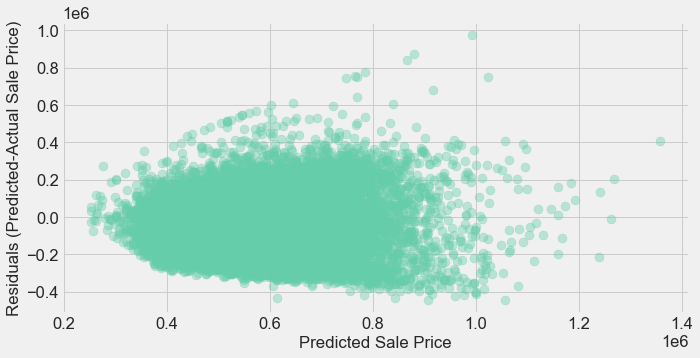

In [394]:
vz.error_plot(model16trim_df, 'SalePrice', model16trim_results)

In [395]:
fn.bp_test(model16trim_df, 'SalePrice', model16trim_results)

Lagrange Multiplier p-value: 0.0
F-statistic p-value: 0.0


#### Result: Fail.
Since our p-value is 0, we reject the null hypothesis and conclude that the variance of the target is not homogeneous across all values of the predictors. This agrees with the error plot above.

### Independence Check:  Variance Inflation Factor

In [396]:
fn.vif(model16trim_df)

,VIF,feature
0,1.399061,SqFtOpenPorch
1,1.026556,SqFtEnclosedPorch
2,1.576362,SqFtDeck
3,1.710278,SqFtFinBasement
4,2.597505,SqFtTotLiving_sqrt
5,1.031041,x0_Floor_Wall
6,1.002706,x0_Gravity
7,1.094837,x0_Heat_Pump
8,1.023351,x0_Hot_Water
9,1.001952,x0_NA


#### Result: Pass
Since all the VIF values are less than five, we conclude the the model is free of multicollinearities.

### Bottom Line on the  Results
R-squared has decreases slightly from .378 to .375. All p-values and CIs are valid except for the `Floor-Wall` and `SqFtEnclosedPorch` categories. The Jarque_Bera p-value is still small and homoscadasticity is still present in the residuals, but looks better than the non-filtered data. The VIF numbers for the features show no multicollinearity. Dropping `Forced Air` has improved the model.

# Regression Findings
The modeling process has uncovered a few overall trends in the data that can be used a basis for testing various client recommendations. All of the models have shown a positive correlation between the `SalePrice` target and `SqFtTotalLiving` predictor. Square-root scaling `SqFtTotLiving` provided the best improvement to model performance. The models have also shown that all other heating types have improved the `SalePrice` target relative to ElecBB heat. Lastly, the models have also shown that the `SqFtOpenPorch`, `SqFtEnclosedPorch`, and `SqFtFinBasement` features are all positively correlated with the target. Focusing on the heating system, porches, and basements makes sense, because these are all features that can be changed or upgraded to increase the sale price of homes.

# Model Assessments:
Model16 B, had the best combination of R-squared and adherence to the assumptions of linear regression. However, it was based of filtered data that has not been fully parsed. A next good step would be more work on the filtered cluster of homes. Hopefully, some clarity can be gain on how they effect the model and steps can be taken to include them in the model, or quantify the effect of leaving them out. Model16 B is also missing the `Forced Air` heating type. Moving forward, a potential next step in the process would be to find a way to add it back in to the model without breaking the independence assuption of linear regression.

# t-Tests on Recommended Improvments
The tests are being run on data with `SalePrice` and `PriceSqFt` outliers removed, but unfiltered by the residuals.

## t-Test: Porches


### t-Test: Strictly Open vs Strictly Enclosed
Homes with only open porches, or enclosed porches.

In [397]:
o = clean_df[(clean_df['SqFtOpenPorch']!=0)&\
             (clean_df['SqFtEnclosedPorch']==0)].SalePrice
e = clean_df[(clean_df['SqFtEnclosedPorch']!=0)&\
             (clean_df['SqFtOpenPorch']==0)].SalePrice

#### The Difference in Average Price Is \$82,926.

In [398]:
o.mean() - e.mean()

82926.36262494233

#### Null & Alternative Hypotheses
Ho: The average sale price of homes with strictly open porches is less than or equal to that of homes with strictly enclosed porches.

Ha: The average sale price of homes with strictly open porches is greater than that of homes with strictly enclosed porches. 

In [399]:
results = stats.ttest_ind(o, e, equal_var=False)

results

Ttest_indResult(statistic=6.000079818781429, pvalue=4.133146736231514e-09)

#### Result: Reject the Null Hypothesis
Since the p-value is less than .05, we reject the null hypothesis and conclude that the average sale price of homes with strictly open porches is greater than that of homes with strictly open porches.

#### Effect Size: Cohen's d = .28
A Cohen's d value of .28 indicates a modest but non-trivial difference in the mean sales prices between the two groups.

In [400]:
fn.cohens_d(o,e)

0.2821730009759876

### Recommendation
Do not convert open porches to closed porches, and, if possible, convert closed porches to open porches.

#### Visualization

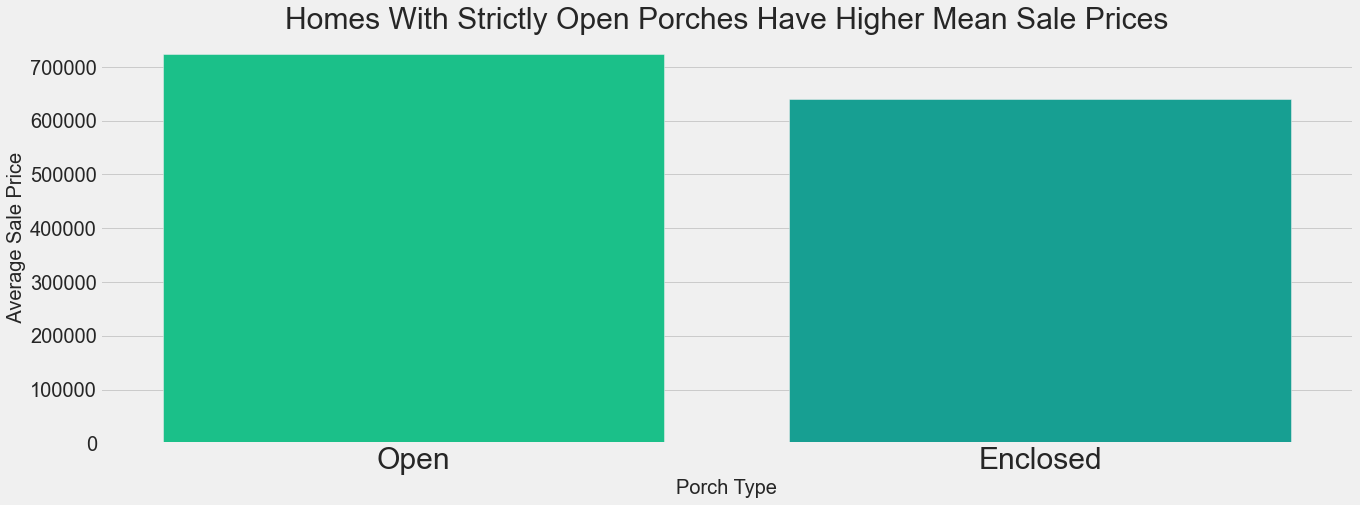

In [401]:
vz.strict_porches(o.mean(),e.mean())

#### Checking for Mixed Cases

In [402]:
len(o), len(e)

(6503, 380)

In [403]:
o2 = clean_df[clean_df['SqFtOpenPorch']!=0].SalePrice
e2 = clean_df[clean_df['SqFtEnclosedPorch']!=0].SalePrice

In [404]:
len(o2) - len(o), len(e2) - len(e)

(269, 269)

## Next Steps: Mixed Cases
There are 269 homes with both open and enclosed porches. Will try to develop a method for untangling the effect of the porches on the mean sale price of these homes as a next step.

## t-Test: Heat Heating Systems

#### Checking the Mean Sale Prices of The Categories
ElecBB and Floor-Wall are the underperformers of the group.

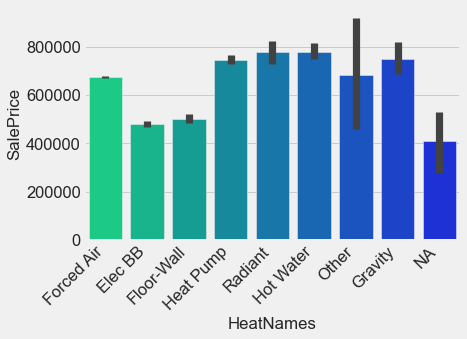

In [405]:
vz.heat_means(initial14_df)

#### Looking Up Codes

In [406]:
fn.lookup(look, 108)

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Grouping ElecBB & Floor-Wall vs All Others

In [407]:
lower = clean_df[(clean_df.HeatSystem == '1') | (clean_df.HeatSystem == '4')].SalePrice
higher = clean_df[(clean_df.HeatSystem != '1')&(clean_df.HeatSystem != '4')].SalePrice

#### The Difference in Average Price Between the Groups is \$197,538.

In [408]:
higher.mean() - lower.mean()

197538.17684688204

#### Null & Alternative Hypotheses
Ho: The average sale prices of homes with ElecBB or Floor-Wall heating are greater than or equal to those of homes with other forms of heating.

Ha: The average sale prices of homes with ElecBB or Floor-Wall heating are less than those of homes with other forms of heating.

In [409]:
result1 = stats.ttest_ind(higher, lower, equal_var=False)

result1

Ttest_indResult(statistic=35.04545638028498, pvalue=6.3394823248834e-216)

#### Result: Reject the Null Hypothesis
Since the p-value is less than .05, we reject the null hypothesis and conclude that the average sale prices of homes with ElecBB or Floor-Wall heating are less than those of homes with other forms of heating.

#### Effect Size: Cohen's d = .72
A Cohen's d value of .72 indicates a significant difference in the mean sale price between the two groups.

In [410]:
fn.cohens_d(higher, lower)

0.7242237475041017

### Further Investigation of the Heating Systems

#### Checking the Number of Each Type

In [411]:
clean_df['HeatSystem'].value_counts()

5    11887
4     1087
7      991
1      451
6      287
3      156
2       35
8       10
0        9
Name: HeatSystem, dtype: int64

#### Checking Code Again

In [412]:
fn.lookup(look, 108)

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Forced Air Accounts For Almost 80% of Heating Systems.

In [413]:
forced_a = clean_df['HeatSystem'].value_counts()[0]
total_h = clean_df['HeatSystem'].value_counts().sum()
forced_a/total_h

0.7970897874337826

# Tukey Test
Running a Tukey of the heating system data for a more in-depth investigation into  the mean differences in sale price.

In [414]:
results = pairwise_tukeyhsd(clean_df.SalePrice, initial13_df.HeatNames)

In [415]:
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Elec BB,Floor-Wall,21940.8982,0.8755,-25256.6656,69138.4621,False
Elec BB,Forced Air,195275.326,0.001,168574.1431,221976.5089,True
Elec BB,Gravity,270491.3997,0.001,125783.5492,415199.2501,True
Elec BB,Heat Pump,265837.6803,0.001,228827.9747,302847.3859,True
Elec BB,Hot Water,300108.8387,0.001,244186.9148,356030.7626,True
Elec BB,NA,-68427.648,0.9,-350469.5978,213614.3019,False
Elec BB,Other,202983.1854,0.3109,-64707.3399,470673.7106,False
Elec BB,Radiant,297636.0764,0.001,225491.6224,369780.5304,True
Floor-Wall,Forced Air,173334.4278,0.001,132910.1342,213758.7213,True
Floor-Wall,Gravity,248550.5014,0.001,100694.0429,396406.9599,True


#### Tukey Test Results
The results above confirm that there are meaningful differences between the mean sale price of homes with the lower performing heating systems (Elec BB & Floor-Wall) and higher performing heating systems (excluding NA & Other). It did not find a meaningful difference between Elec BB and Floor-Wall. The preliminary recommendation is for ElecBB & Floor-wall systems to be upgraded.

### Recomendation
Upgrade ElecBB & Floor-Wall heating systems to different heating type (excluding the NA & Other categories).

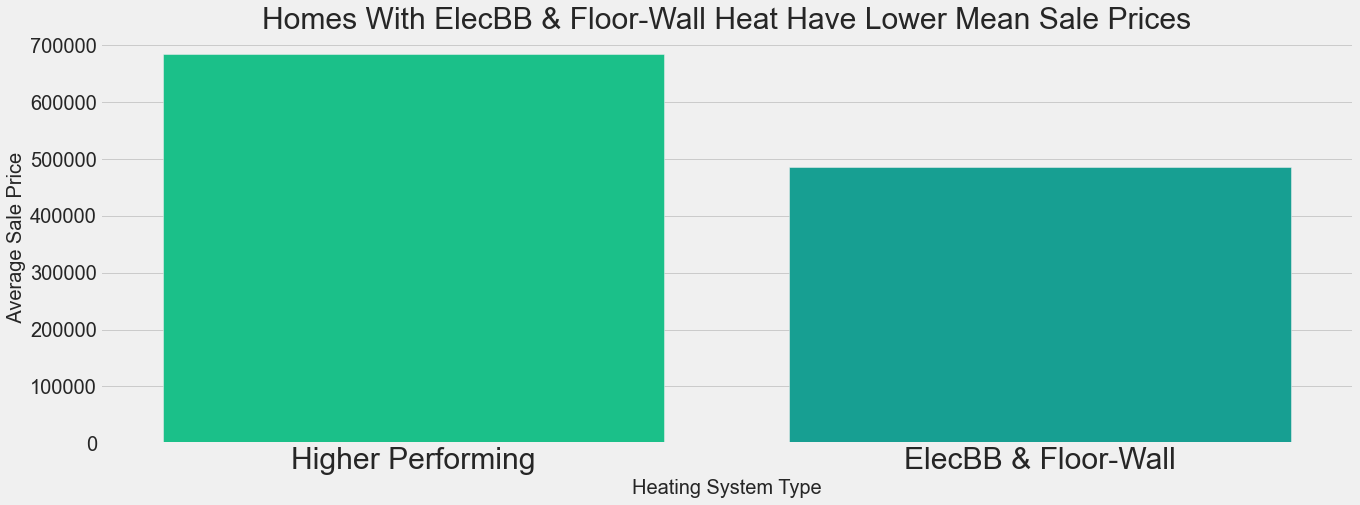

In [416]:
vz.elecbb(higher,lower)

# Next Steps: Futher Analysis of Heating Systems
More exploration into the higher-perfoming heat systems to dig the upgrade cost vs effect on the mean sale price of homes between the different types.

## t-tests: Basement Upgrades

#### Checking Codes

In [417]:
fn.lookup(look, '82')

,LUType,LUItem,LUDescription
1150,82,1,1 Cabin
1151,82,10,10 Very Good
1152,82,11,11 Excellent
1153,82,12,12 Luxury
1154,82,13,13 Mansion
1155,82,2,2 Substandard
1156,82,20,Exceptional Properties
1157,82,3,3 Poor
1158,82,4,4 Low
1159,82,5,5 Fair


### t-Test: Finished vs Unfinished Basements

In [418]:
# adding a numerical basement grade column
clean_df['FinBasementGradeInt'] = clean_df['FinBasementGrade'].astype(int)

In [419]:
finished = clean_df[clean_df['FinBasementGradeInt'] != 0].SalePrice
unfinished = clean_df[clean_df['FinBasementGradeInt'] == 0].SalePrice

#### The Difference in Average Price Between the Two Groups is \$112,250.

In [420]:
finished.mean() - unfinished.mean()

112250.62646270939

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with finished basements is less than or equal to that of a homes with unfinished basements.

Ha: The mean sale price of homes with finished basements is higher than that of homes with unfinished basements.

In [421]:
result2 = stats.ttest_ind(finished, unfinished, equal_var=False)

result2

Ttest_indResult(statistic=24.445192659259256, pvalue=5.314302329646943e-129)

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that homes with finished basements have a higher mean sale price than homes with unfinished basements.

#### Effect Size: Cohen's d = .41
A value of .41 indicates a moderate difference in the mean sale price between the two groups.

In [422]:
fn.cohens_d(finished, unfinished)

0.40994905309378415

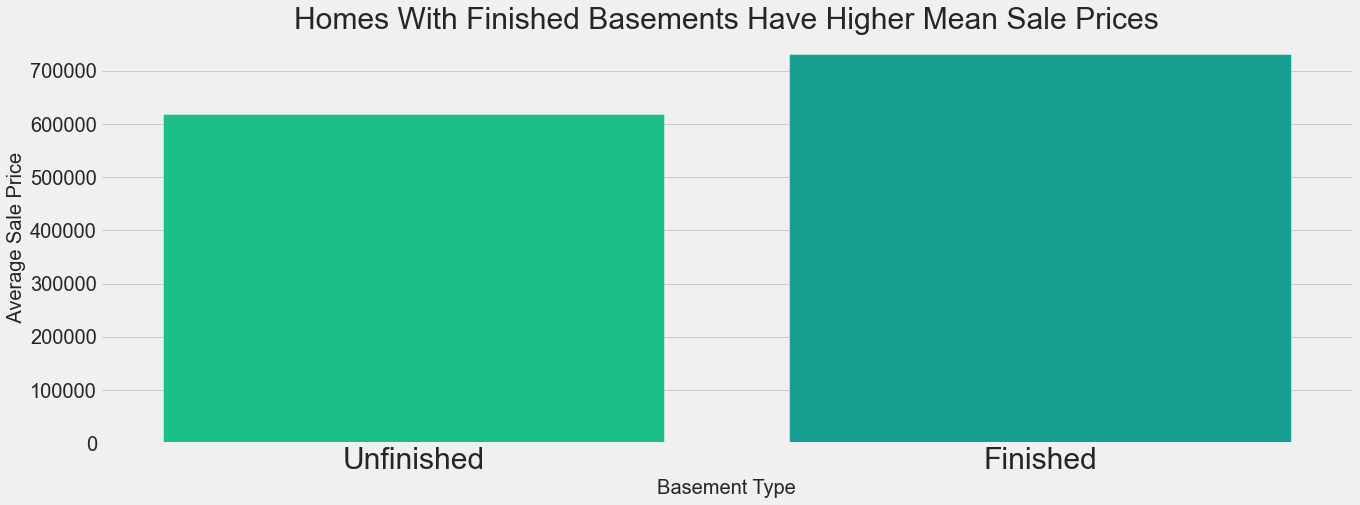

In [423]:
vz.finished(unfinished, finished)

### t-Test: Poor vs Fair Quality Basements

In [424]:
poor = clean_df[(clean_df['FinBasementGradeInt'] > 0)&(clean_df['FinBasementGradeInt']<4)].SalePrice
fair = clean_df[(clean_df['FinBasementGradeInt'] >= 4)&(clean_df['FinBasementGradeInt']<7)].SalePrice

#### The difference in average sale price appears to be \$135,335.

In [425]:
fair.mean() - poor.mean()

135335.19185499055

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with fair quality basements is less than or equal to that of a homes with poor quality basements.

Ha: The mean sale price of homes with fair quality basements is higher than that of homes with poor quality basements.

In [426]:
result3 = stats.ttest_ind(poor, fair, equal_var=False)

In [427]:
result3

Ttest_indResult(statistic=-2.012160070091966, pvalue=0.07858450136299434)

### Result: Fail to Reject the Null Hypothesis
Since the p-value of the t-test is above alpha=.05, we fail to reject the null hypothesis and conclude that the mean sale price of homes with fair quality basements is less than or equal to that of a homes with poor quality basements.

## t-Test: Average vs Poor Quality Basements

In [428]:
average = clean_df[clean_df['FinBasementGradeInt'] == 7].SalePrice

#### The difference in mean sale prices appears to be \$197879.

In [429]:
average.mean() - poor.mean()

197879.5049833887

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with average quality basements is less than or equal to that of a homes with poor quality basements.

Ha: The mean sale price of homes with higher quality basements is higher than that of homes with average quality basements.

In [430]:
result4 = stats.ttest_ind(average, poor, equal_var=False)

In [431]:
result4

Ttest_indResult(statistic=2.9421074960132163, pvalue=0.01840475612778365)

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that the mean sale price of homes with higher quality basements is greater than that of a homes with average  quality basements.

#### Effect Size: Cohen's d = .73
Cohen's d value of 1.47 indicates a significant difference in mean sale price between the to groups.

In [432]:
fn.cohens_d(average, poor)

0.7290526734102526

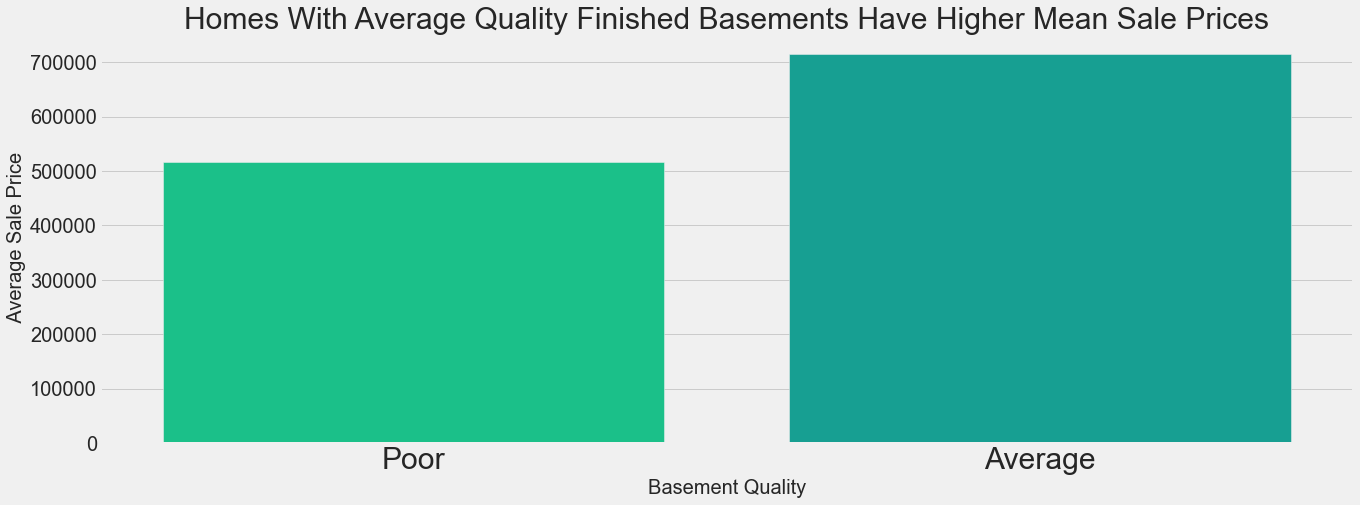

In [433]:
vz.po_ave(poor, average)

## t-Test: Average vs Higher Quality Basements

In [434]:
upgrade = clean_df[clean_df['FinBasementGradeInt'] > 8].SalePrice

#### The difference in mean sale prices appears to be \$321349.

In [435]:
upgrade.mean() - average.mean()

321349.25121941604

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with higher quality basements is less than or equal to that of a homes with average quality basements.

Ha: The mean sale price of homes with higher quality basements is higher than that of homes with average quality basements.

In [436]:
result5 = stats.ttest_ind(average, upgrade, equal_var=False)

In [437]:
result5

Ttest_indResult(statistic=-20.693055041200797, pvalue=9.18847641959381e-65)

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that the mean sale price of homes with higher quality basements is greater than that of a homes with average  quality basements.

#### Effect Size: Cohen's d = 1.19
Cohen's d value of 1.47 indicates a large difference in mean sale price between the to groups.

In [438]:
fn.cohens_d(upgrade, average)

1.1894940590920275

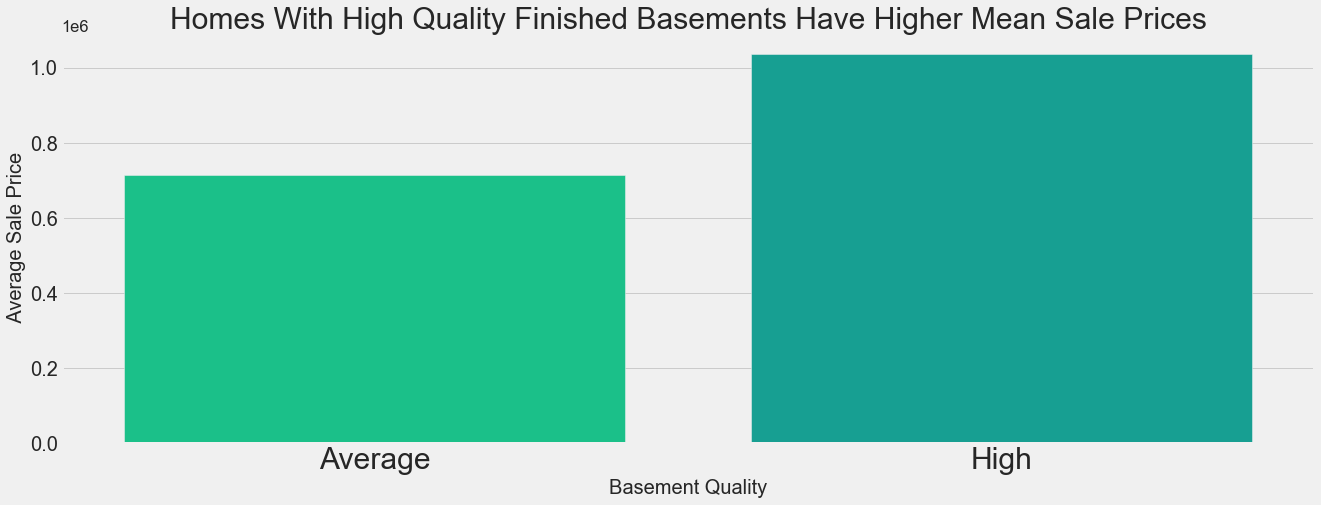

In [439]:
vz.ave_hi(average, upgrade)

## t-Test: Poor vs Higher Quality

The difference in average mean prices appears to be \$519228.

In [440]:
upgrade.mean() - poor.mean()

519228.75620280474

#### Null & Alternative Hypotheses
Ho: The mean sale price of homes with higher quality basements is less than or equal to that of a homes with poor quality basements.

Ha: The mean sale price of homes with higher quality basements is higher than that of homes with poor quality basements.

In [441]:
result6 = stats.ttest_ind(poor, upgrade, equal_var=False)

In [442]:
result6

Ttest_indResult(statistic=-7.5654419912091635, pvalue=3.952104345449833e-05)

#### Result: Reject the Null Hypothesis
Since the p-value of the t-test is below alpha=.05, we reject the null hypothesis and conclude that the mean sale price of homes with higher quality basements is greater than that of homes with poor  quality basements.

#### Effect Size: Cohen's d = 2.03
A value of 2.03 indicates a very large difference in mean sale price between the two groups. 

In [443]:
fn.cohens_d(upgrade, poor)

2.0294880114463956

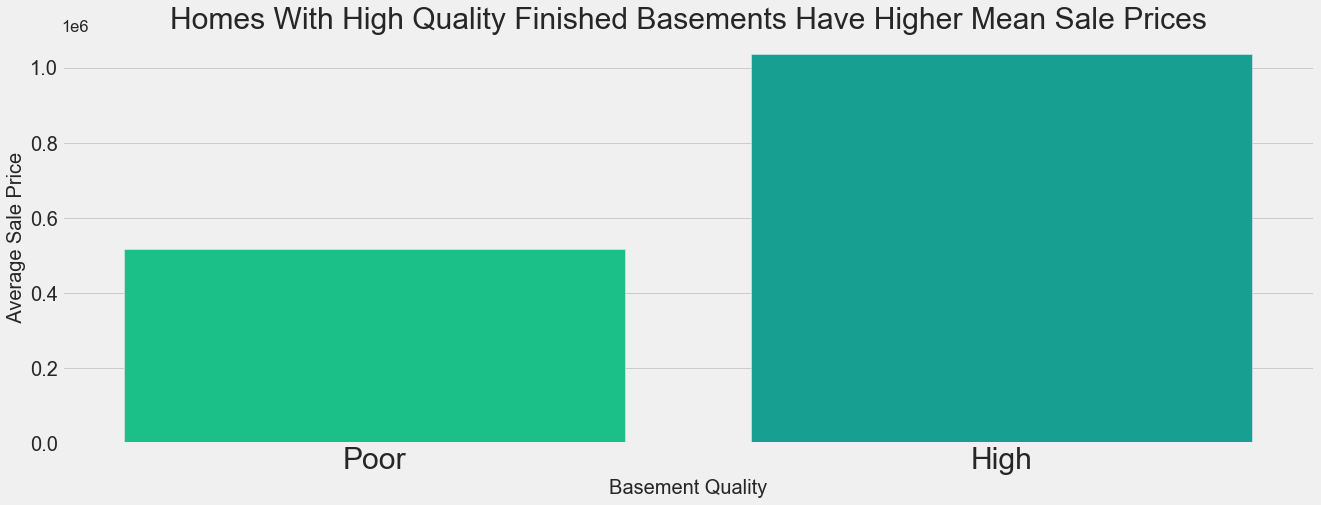

In [444]:
vz.po_hi(poor,upgrade)

## Recommendations
Upgrade basements up to a finished quality level of at least average.

#### Next Steps
Quanitify the characteristics that demarcate the various quality levels for finished basements.

# Final Recommendations
* Do not enclose porches; If possible, convert enclosed porches to open porches.
* Upgrade Electric Baseboard & Floor-Wall heating systems.
* Upgrade basements up to a finished quality level of at least average.

# Next Steps

* Doing further analysis on the group of homes in the problematic tip of the residuals plot to determine which features the have in common, and how those features affect the models specifically and home prices more generally.

* More exploration into the higher-perfoming heat systems to dig the upgrade cost vs effect on the mean sale price of homes between the different types.

* Developing a method to test the effect of porchs on the sale price of the 269 homes with both open and closed porches.

* Quanitify the characteristics that demarcate the various quality levels for finished basements.

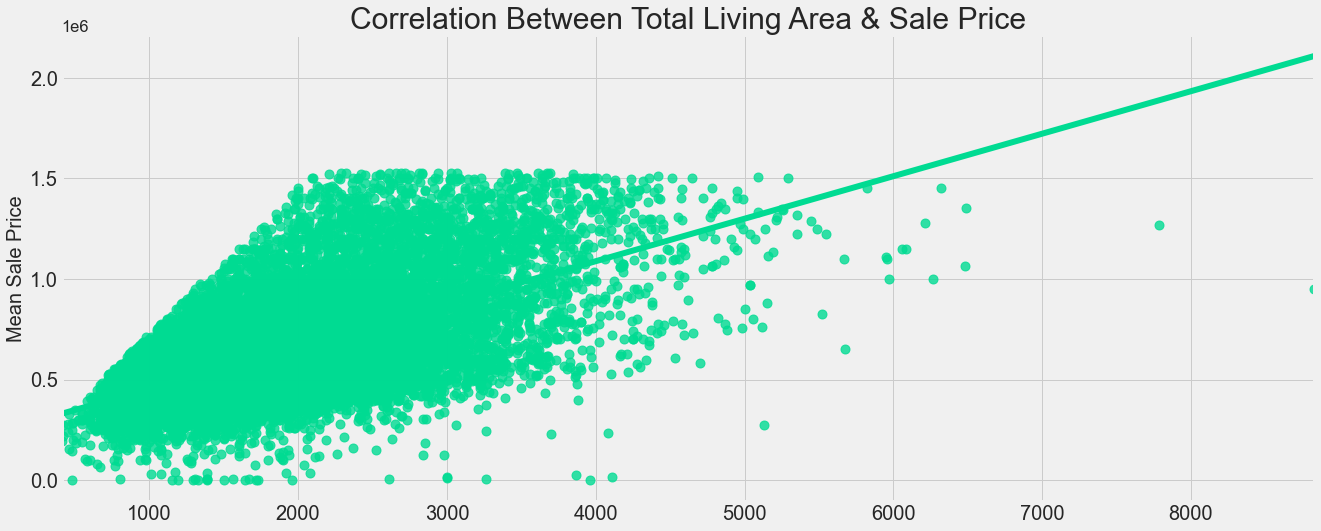

In [445]:
vz.corr_area_price(clean_df)